## Setup

In [3]:
!pip3 install cornac

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 53.8 MB/s eta 0:00:00


In [4]:
!pip3 install git+https://github.com/PreferredAI/cornac.git

  Cloning https://github.com/PreferredAI/cornac.git to /tmp/pip-req-build-ywegt4y_
  Running command git clone --filter=blob:none --quiet https://github.com/PreferredAI/cornac.git /tmp/pip-req-build-ywegt4y_
  Resolved https://github.com/PreferredAI/cornac.git to commit 52979eb5d4acf1f20e24ece5977c05e5ec5b24e7
  Preparing metadata (setup.py) ... done


In [5]:
import os
import sys
import json

import pandas as pd
import numpy as np
import cornac
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats, sparse
from cornac.data import Dataset

import itertools

import scipy.sparse as sp
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
#from adjustText import adjust_text

import cornac
from cornac.utils import cache
from cornac.datasets import movielens
from cornac.eval_methods import RatioSplit
from cornac.models import MF, NMF, BaselineOnly
import cornac
from cornac.utils import cache
from cornac.datasets import movielens
from cornac.models import UserKNN, ItemKNN
from cornac.models import BPR
from cornac.metrics import Precision, Recall
from cornac.hyperopt import GridSearch, RandomSearch, Discrete, Continuous
from cornac.data import Reader
from cornac.models import MF, BPR, WMF,NeuMF
from cornac.eval_methods import BaseMethod
from cornac.eval_methods import CrossValidation
from cornac.models import PMF, SoRec, WMF, CTR, BPR, VBPR
from cornac.data import GraphModality, TextModality, ImageModality
from cornac.data.text import BaseTokenizer
from sklearn.model_selection import KFold
import subprocess
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import numpy as np


%matplotlib inline

print(f"System version: {sys.version}")
print(f"Cornac version: {cornac.__version__}")
print(pd.__version__)

System version: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
Cornac version: 2.2.1
2.0.3


In [6]:
# Hoshea's path
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')
ratings_path = '/content/drive/MyDrive/SMU_MITB_RS/GrpProject/ratings.csv'
movies_path =  '/content/drive/MyDrive/SMU_MITB_RS/GrpProject/movies.csv'
tmdb_movies_path = '/content/drive/MyDrive/SMU_MITB_RS/GrpProject/tmdb_5000_movies.csv'
tmdb_credits_path =  '/content/drive/MyDrive/SMU_MITB_RS/GrpProject/tmdb_5000_credits.csv'

# Read the file into a pandas DataFrame
df_ratings = pd.read_csv(ratings_path)
df_movies = pd.read_csv(movies_path)
df_tmdb_movies = pd.read_csv(tmdb_movies_path)
df_tmdb_credits = pd.read_csv(tmdb_credits_path)

Mounted at /content/drive


In [7]:
!pip3 install --user -r /content/drive/MyDrive/SMU_MITB_RS/GrpProject/requirements.txt

ERROR: Could not open requirements file: [Errno 2] No such file or directory: '/content/drive/MyDrive/SMU_MITB_RS/GrpProject/requirements.txt'


In [8]:
!pip show tensorflow

Name: tensorflow
Version: 2.15.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, setuptools, six, tensorboard, tensorflow-estimator, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: deepctr-torch, dopamine_rl, tf_keras


In [9]:
!git clone https://github.com/srendle/libfm.git
!make all -C libfm

Cloning into 'libfm'...
remote: Enumerating objects: 233, done.
remote: Total 233 (delta 0), reused 0 (delta 0), pack-reused 233
Receiving objects: 100% (233/233), 129.46 KiB | 1.88 MiB/s, done.
Resolving deltas: 100% (112/112), done.
make: Entering directory '/content/libfm'
cd src/libfm; make all
make[1]: Entering directory '/content/libfm/src/libfm'
g++ -O3 -Wall -c libfm.cpp -o libfm.o
mkdir -p ../../bin/
g++ -O3 -Wall libfm.o -o ../../bin/libFM
g++ -O3 -Wall -c tools/transpose.cpp -o tools/transpose.o
mkdir -p ../../bin/
g++ -O3 tools/transpose.o -o ../../bin/transpose
g++ -O3 -Wall -c tools/convert.cpp -o tools/convert.o
mkdir -p ../../bin/
g++ -O3 tools/convert.o -o ../../bin/convert
make[1]: Leaving directory '/content/libfm/src/libfm'
make: Leaving directory '/content/libfm'


## Data Exploration

In [ ]:
df_ratings.head()

,userId,movieId,rating,timestamp
0,1,16,4.0,1217897793
1,1,24,1.5,1217895807
2,1,32,4.0,1217896246
3,1,47,4.0,1217896556
4,1,50,4.0,1217896523


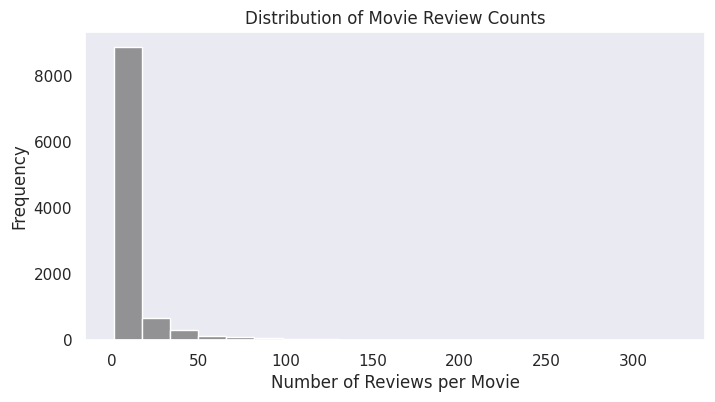

In [ ]:
movie_rating_counts = df_ratings['movieId'].value_counts()

sns.set(style="dark")
plt.figure(figsize=(8, 4))
sns.histplot(movie_rating_counts, bins=20, kde=False, color='#757575')
plt.title('Distribution of Movie Review Counts')
plt.xlabel('Number of Reviews per Movie')
plt.ylabel('Frequency')
plt.show()


In [ ]:
unique_movie_ids = df_ratings['movieId'].unique()
unique_movie_count = len(unique_movie_ids)
print(unique_movie_count)

10325


In [ ]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105339 entries, 0 to 105338
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     105339 non-null  int64  
 1   movieId    105339 non-null  int64  
 2   rating     105339 non-null  float64
 3   timestamp  105339 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.2 MB


In [ ]:
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10329 entries, 0 to 10328
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  10329 non-null  int64 
 1   title    10329 non-null  object
 2   genres   10329 non-null  object
dtypes: int64(1), object(2)
memory usage: 242.2+ KB


In [ ]:
df_tmdb_movies.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


In [ ]:
df_tmdb_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4803 non-null   int64  
 1   genres                4803 non-null   object 
 2   homepage              1712 non-null   object 
 3   id                    4803 non-null   int64  
 4   keywords              4803 non-null   object 
 5   original_language     4803 non-null   object 
 6   original_title        4803 non-null   object 
 7   overview              4800 non-null   object 
 8   popularity            4803 non-null   float64
 9   production_companies  4803 non-null   object 
 10  production_countries  4803 non-null   object 
 11  release_date          4802 non-null   object 
 12  revenue               4803 non-null   int64  
 13  runtime               4801 non-null   float64
 14  spoken_languages      4803 non-null   object 
 15  status               

In [ ]:
df_tmdb_movies['overview'][0]

'In the 22nd century, a paraplegic Marine is dispatched to the moon Pandora on a unique mission, but becomes torn between following orders and protecting an alien civilization.'

In [ ]:
df_tmdb_movies['runtime'][0]

162.0

In [ ]:
df_tmdb_movies['overview'][1]

'Captain Barbossa, long believed to be dead, has come back to life and is headed to the edge of the Earth with Will Turner and Elizabeth Swann. But nothing is quite as it seems.'

In [ ]:
df_tmdb_movies['production_companies'][1]

'[{"name": "Walt Disney Pictures", "id": 2}, {"name": "Jerry Bruckheimer Films", "id": 130}, {"name": "Second Mate Productions", "id": 19936}]'

In [ ]:
df_tmdb_credits.head()

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


In [ ]:
df_tmdb_credits['crew'][0]

'[{"credit_id": "52fe48009251416c750aca23", "department": "Editing", "gender": 0, "id": 1721, "job": "Editor", "name": "Stephen E. Rivkin"}, {"credit_id": "539c47ecc3a36810e3001f87", "department": "Art", "gender": 2, "id": 496, "job": "Production Design", "name": "Rick Carter"}, {"credit_id": "54491c89c3a3680fb4001cf7", "department": "Sound", "gender": 0, "id": 900, "job": "Sound Designer", "name": "Christopher Boyes"}, {"credit_id": "54491cb70e0a267480001bd0", "department": "Sound", "gender": 0, "id": 900, "job": "Supervising Sound Editor", "name": "Christopher Boyes"}, {"credit_id": "539c4a4cc3a36810c9002101", "department": "Production", "gender": 1, "id": 1262, "job": "Casting", "name": "Mali Finn"}, {"credit_id": "5544ee3b925141499f0008fc", "department": "Sound", "gender": 2, "id": 1729, "job": "Original Music Composer", "name": "James Horner"}, {"credit_id": "52fe48009251416c750ac9c3", "department": "Directing", "gender": 2, "id": 2710, "job": "Director", "name": "James Cameron"},

In [ ]:
df_tmdb_movies['keywords'][0]

'[{"id": 1463, "name": "culture clash"}, {"id": 2964, "name": "future"}, {"id": 3386, "name": "space war"}, {"id": 3388, "name": "space colony"}, {"id": 3679, "name": "society"}, {"id": 3801, "name": "space travel"}, {"id": 9685, "name": "futuristic"}, {"id": 9840, "name": "romance"}, {"id": 9882, "name": "space"}, {"id": 9951, "name": "alien"}, {"id": 10148, "name": "tribe"}, {"id": 10158, "name": "alien planet"}, {"id": 10987, "name": "cgi"}, {"id": 11399, "name": "marine"}, {"id": 13065, "name": "soldier"}, {"id": 14643, "name": "battle"}, {"id": 14720, "name": "love affair"}, {"id": 165431, "name": "anti war"}, {"id": 193554, "name": "power relations"}, {"id": 206690, "name": "mind and soul"}, {"id": 209714, "name": "3d"}]'

In [ ]:
df_tmdb_credits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   movie_id  4803 non-null   int64 
 1   title     4803 non-null   object
 2   cast      4803 non-null   object
 3   crew      4803 non-null   object
dtypes: int64(1), object(3)
memory usage: 150.2+ KB


In [ ]:
df_tmdb_credits.tail()

,movie_id,title,cast,crew
4798,9367,El Mariachi,"[{""cast_id"": 1, ""character"": ""El Mariachi"", ""c...","[{""credit_id"": ""52fe44eec3a36847f80b280b"", ""de..."
4799,72766,Newlyweds,"[{""cast_id"": 1, ""character"": ""Buzzy"", ""credit_...","[{""credit_id"": ""52fe487dc3a368484e0fb013"", ""de..."
4800,231617,"Signed, Sealed, Delivered","[{""cast_id"": 8, ""character"": ""Oliver O\u2019To...","[{""credit_id"": ""52fe4df3c3a36847f8275ecf"", ""de..."
4801,126186,Shanghai Calling,"[{""cast_id"": 3, ""character"": ""Sam"", ""credit_id...","[{""credit_id"": ""52fe4ad9c3a368484e16a36b"", ""de..."
4802,25975,My Date with Drew,"[{""cast_id"": 3, ""character"": ""Herself"", ""credi...","[{""credit_id"": ""58ce021b9251415a390165d9"", ""de..."


In [ ]:
movie_title = df_tmdb_credits.loc[df_tmdb_credits['movie_id'] == 100, 'title'].values[0]
print(movie_title)
movie_title_2 = df_tmdb_movies.loc[df_tmdb_movies['id'] == 100,'title'].values[0]
print(movie_title_2)
movie_title_3 = df_movies.loc[df_movies['movieId'] == 100,'title'].values[0]
print(movie_title_3)

Lock, Stock and Two Smoking Barrels
Lock, Stock and Two Smoking Barrels
City Hall (1996)


In [ ]:
df_tmdb_credits['cast'][1]

'[{"cast_id": 4, "character": "Captain Jack Sparrow", "credit_id": "52fe4232c3a36847f800b50d", "gender": 2, "id": 85, "name": "Johnny Depp", "order": 0}, {"cast_id": 5, "character": "Will Turner", "credit_id": "52fe4232c3a36847f800b511", "gender": 2, "id": 114, "name": "Orlando Bloom", "order": 1}, {"cast_id": 6, "character": "Elizabeth Swann", "credit_id": "52fe4232c3a36847f800b515", "gender": 1, "id": 116, "name": "Keira Knightley", "order": 2}, {"cast_id": 12, "character": "William \\"Bootstrap Bill\\" Turner", "credit_id": "52fe4232c3a36847f800b52d", "gender": 2, "id": 1640, "name": "Stellan Skarsg\\u00e5rd", "order": 3}, {"cast_id": 10, "character": "Captain Sao Feng", "credit_id": "52fe4232c3a36847f800b525", "gender": 2, "id": 1619, "name": "Chow Yun-fat", "order": 4}, {"cast_id": 9, "character": "Captain Davy Jones", "credit_id": "52fe4232c3a36847f800b521", "gender": 2, "id": 2440, "name": "Bill Nighy", "order": 5}, {"cast_id": 7, "character": "Captain Hector Barbossa", "credit_

In [ ]:
df_tmdb_credits['crew'][1]

'[{"credit_id": "52fe4232c3a36847f800b579", "department": "Camera", "gender": 2, "id": 120, "job": "Director of Photography", "name": "Dariusz Wolski"}, {"credit_id": "52fe4232c3a36847f800b4fd", "department": "Directing", "gender": 2, "id": 1704, "job": "Director", "name": "Gore Verbinski"}, {"credit_id": "52fe4232c3a36847f800b54f", "department": "Production", "gender": 2, "id": 770, "job": "Producer", "name": "Jerry Bruckheimer"}, {"credit_id": "52fe4232c3a36847f800b503", "department": "Writing", "gender": 2, "id": 1705, "job": "Screenplay", "name": "Ted Elliott"}, {"credit_id": "52fe4232c3a36847f800b509", "department": "Writing", "gender": 2, "id": 1706, "job": "Screenplay", "name": "Terry Rossio"}, {"credit_id": "52fe4232c3a36847f800b57f", "department": "Editing", "gender": 0, "id": 1721, "job": "Editor", "name": "Stephen E. Rivkin"}, {"credit_id": "52fe4232c3a36847f800b585", "department": "Editing", "gender": 2, "id": 1722, "job": "Editor", "name": "Craig Wood"}, {"credit_id": "52f

In [ ]:
print('The number of movies rated by users:{}'.format(len(df_ratings['movieId'].unique())))
print('The number of users rated :{}'.format(len(df_ratings['userId'].unique())))

The number of movies rated by users:10325
The number of users rated :668


## Data Processing

### TF-IDF

In [ ]:
df_overview = df_tmdb_movies[['overview']].astype(str)
print(df_overview.head(10))

                                            overview
0  In the 22nd century, a paraplegic Marine is di...
1  Captain Barbossa, long believed to be dead, ha...
2  A cryptic message from Bond’s past sends him o...
3  Following the death of District Attorney Harve...
4  John Carter is a war-weary, former military ca...
5  The seemingly invincible Spider-Man goes up ag...
6  When the kingdom's most wanted-and most charmi...
7  When Tony Stark tries to jumpstart a dormant p...
8  As Harry begins his sixth year at Hogwarts, he...
9  Fearing the actions of a god-like Super Hero l...


In [ ]:
###overview tokenizer
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
import string
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
###overview tokenizer
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
###overview tokenizer
#'/content/drive/MyDrive/SMU_MITB_RS/GrpProject/overview_keywords_sample.csv'

vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(df_overview['overview'])


feature_names = vectorizer.get_feature_names_out()


def get_top_keywords(row, feature_names, top_n=5):
    row_data = row.toarray().flatten()
    top_indices = row_data.argsort()[-top_n:][::-1]
    return [feature_names[i] for i in top_indices]

keywords = [get_top_keywords(row, feature_names) for row in tfidf_matrix]


df_overview['keywords'] = keywords

output_path = '/content/drive/MyDrive/SMU_MITB_RS/GrpProject/overview_keywords.csv'
df_overview.to_csv(output_path, index=False)

output_path

'/content/drive/MyDrive/SMU_MITB_RS/GrpProject/overview_keywords.csv'

### Preprocess for text data

In [ ]:
# rename id of df_tmdb_movies to movie_id for merge
df_tmdb_movies.rename(columns={'id' :'movie_id'},inplace =True)

# movie id check
df_tmdb_credits['movie_id'] = pd.to_numeric(df_tmdb_credits['movie_id'], errors='coerce')
df_tmdb_credits = df_tmdb_credits.dropna(subset=['movie_id'])

# merge two df
df_combine = pd.merge(df_tmdb_credits,df_tmdb_movies,on = 'movie_id')
df_combine = df_combine.sort_values(by='movie_id')

In [ ]:
df_combine2 = pd.merge(df_tmdb_credits,df_tmdb_movies,on = 'movie_id')

In [ ]:
df_combine.head()

,movie_id,title_x,cast,crew,budget,genres,homepage,keywords,original_language,original_title,...,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title_y,vote_average,vote_count
3766,5,Four Rooms,"[{""cast_id"": 42, ""character"": ""Ted the Bellhop...","[{""credit_id"": ""52fe420dc3a36847f800012d"", ""de...",4000000,"[{""id"": 80, ""name"": ""Crime""}, {""id"": 35, ""name...",NaN,"[{""id"": 612, ""name"": ""hotel""}, {""id"": 613, ""na...",en,Four Rooms,...,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1995-12-09,4300000,98.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,Twelve outrageous guests. Four scandalous requ...,Four Rooms,6.5,530
2912,11,Star Wars,"[{""cast_id"": 3, ""character"": ""Luke Skywalker"",...","[{""credit_id"": ""52fe420dc3a36847f8000437"", ""de...",11000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 28, ""...",http://www.starwars.com/films/star-wars-episod...,"[{""id"": 803, ""name"": ""android""}, {""id"": 4270, ...",en,Star Wars,...,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1977-05-25,775398007,121.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"A long time ago in a galaxy far, far away...",Star Wars,8.1,6624
328,12,Finding Nemo,"[{""cast_id"": 8, ""character"": ""Marlin (voice)"",...","[{""credit_id"": ""52fe420ec3a36847f80006b1"", ""de...",94000000,"[{""id"": 16, ""name"": ""Animation""}, {""id"": 10751...",http://movies.disney.com/finding-nemo,"[{""id"": 494, ""name"": ""father son relationship""...",en,Finding Nemo,...,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2003-05-30,940335536,100.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"There are 3.7 trillion fish in the ocean, they...",Finding Nemo,7.6,6122
809,13,Forrest Gump,"[{""cast_id"": 7, ""character"": ""Forrest Gump"", ""...","[{""credit_id"": ""52fe420ec3a36847f800076b"", ""de...",55000000,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 18, ""nam...",NaN,"[{""id"": 422, ""name"": ""vietnam veteran""}, {""id""...",en,Forrest Gump,...,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1994-07-06,677945399,142.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"The world will never be the same, once you've ...",Forrest Gump,8.2,7927
2516,14,American Beauty,"[{""cast_id"": 6, ""character"": ""Lester Burnham"",...","[{""credit_id"": ""52fe420ec3a36847f8000809"", ""de...",15000000,"[{""id"": 18, ""name"": ""Drama""}]",http://www.dreamworks.com/ab/,"[{""id"": 255, ""name"": ""male nudity""}, {""id"": 29...",en,American Beauty,...,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1999-09-15,356296601,122.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,Look closer.,American Beauty,7.9,3313


In [ ]:
print('The shape of combie DataFeame is',df_combine.shape)

The shape of combie DataFeame is (4803, 23)


In [ ]:
df_combine.tail()

,movie_id,title_x,cast,crew,budget,genres,homepage,keywords,original_language,original_title,...,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title_y,vote_average,vote_count
4625,426067,Midnight Cabaret,"[{""cast_id"": 1, ""character"": ""Dawn"", ""credit_i...","[{""credit_id"": ""582a4cdb9251417b1803dd47"", ""de...",0,"[{""id"": 27, ""name"": ""Horror""}]",NaN,[],en,Midnight Cabaret,...,[],1990-01-01,0,94.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The hot spot where Satan's waitin'.,Midnight Cabaret,0.0,0
4255,426469,Growing Up Smith,"[{""cast_id"": 4, ""character"": ""Smith Bhatnagar""...","[{""credit_id"": ""582e0bdfc3a368772600b6c1"", ""de...",0,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 10751, ""...",http://www.growingupsmithmovie.com,[],en,Growing Up Smith,...,[],2017-02-03,0,102.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,It’s better to stand out than to fit in.,Growing Up Smith,7.4,7
4051,433715,8 Days,"[{""cast_id"": 3, ""character"": ""Amber"", ""credit_...","[{""credit_id"": ""58713acfc3a3684f0a00a9ac"", ""de...",0,"[{""id"": 53, ""name"": ""Thriller""}, {""id"": 18, ""n...",NaN,"[{""id"": 10060, ""name"": ""christian film""}, {""id...",en,8 Days,...,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2014-06-15,0,90.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,She never knew it could happen to her...,8 Days,0.0,0
3670,447027,Running Forever,[],[],0,"[{""id"": 10751, ""name"": ""Family""}]",NaN,[],en,Running Forever,...,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2015-10-27,0,88.0,[],Released,NaN,Running Forever,0.0,0
4140,459488,"To Be Frank, Sinatra at 100","[{""cast_id"": 0, ""character"": ""Narrator"", ""cred...","[{""credit_id"": ""592b25e4c3a368783e065a2f"", ""de...",2,"[{""id"": 99, ""name"": ""Documentary""}]",NaN,"[{""id"": 6027, ""name"": ""music""}, {""id"": 225822,...",en,"To Be Frank, Sinatra at 100",...,"[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""}]",2015-12-12,0,NaN,[],Released,NaN,"To Be Frank, Sinatra at 100",0.0,0


In [ ]:
print(df_combine.columns)

Index(['movie_id', 'title_x', 'cast', 'crew', 'budget', 'genres', 'homepage',
       'keywords', 'original_language', 'original_title', 'overview',
       'popularity', 'production_companies', 'production_countries',
       'release_date', 'revenue', 'runtime', 'spoken_languages', 'status',
       'tagline', 'title_y', 'vote_average', 'vote_count'],
      dtype='object')


In [ ]:
from ast import literal_eval

features = ['cast', 'crew', 'keywords', 'genres','production_companies']
for feature in features:
    df_combine[feature] = df_combine[feature].apply(literal_eval)

In [ ]:
# create new DataFrame of text data
df_text = pd.DataFrame(df_combine[['movie_id','original_title','cast','crew','keywords','genres','production_companies']])
df_text.reset_index(drop = True,inplace=True)

In [ ]:
df_text.head()

,movie_id,original_title,cast,crew,keywords,genres,production_companies
0,5,Four Rooms,"[{'cast_id': 42, 'character': 'Ted the Bellhop...","[{'credit_id': '52fe420dc3a36847f800012d', 'de...","[{'id': 612, 'name': 'hotel'}, {'id': 613, 'na...","[{'id': 80, 'name': 'Crime'}, {'id': 35, 'name...","[{'name': 'Miramax Films', 'id': 14}, {'name':..."
1,11,Star Wars,"[{'cast_id': 3, 'character': 'Luke Skywalker',...","[{'credit_id': '52fe420dc3a36847f8000437', 'de...","[{'id': 803, 'name': 'android'}, {'id': 4270, ...","[{'id': 12, 'name': 'Adventure'}, {'id': 28, '...","[{'name': 'Lucasfilm', 'id': 1}, {'name': 'Twe..."
2,12,Finding Nemo,"[{'cast_id': 8, 'character': 'Marlin (voice)',...","[{'credit_id': '52fe420ec3a36847f80006b1', 'de...","[{'id': 494, 'name': 'father son relationship'...","[{'id': 16, 'name': 'Animation'}, {'id': 10751...","[{'name': 'Pixar Animation Studios', 'id': 3}]"
3,13,Forrest Gump,"[{'cast_id': 7, 'character': 'Forrest Gump', '...","[{'credit_id': '52fe420ec3a36847f800076b', 'de...","[{'id': 422, 'name': 'vietnam veteran'}, {'id'...","[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...","[{'name': 'Paramount Pictures', 'id': 4}]"
4,14,American Beauty,"[{'cast_id': 6, 'character': 'Lester Burnham',...","[{'credit_id': '52fe420ec3a36847f8000809', 'de...","[{'id': 255, 'name': 'male nudity'}, {'id': 29...","[{'id': 18, 'name': 'Drama'}]","[{'name': 'DreamWorks SKG', 'id': 27}, {'name'..."


In [ ]:
# def helper function to extract information

def get_director(df):
  for row in df:
    if row['job'] == 'Director':
      return row['name']

  return np.nan

def get_top(df):
  if isinstance(df,list):
    names = [row['name'] for row in df]
  if len(names) > 3:
    names = names[:3]
  return names

  return []

df_text['director'] = df_text['crew'].apply(get_director)
df_text.drop('crew',axis = 1,inplace = True)

features = ['cast', 'keywords', 'genres','production_companies']
for feature in features:
    df_text[feature] = df_text[feature].apply(get_top)


In [ ]:
df_text.head()

,movie_id,original_title,cast,keywords,genres,production_companies,director
0,5,Four Rooms,"[Tim Roth, Antonio Banderas, Jennifer Beals]","[hotel, new year's eve, witch]","[Crime, Comedy]","[Miramax Films, A Band Apart]",Allison Anders
1,11,Star Wars,"[Mark Hamill, Harrison Ford, Carrie Fisher]","[android, galaxy, hermit]","[Adventure, Action, Science Fiction]","[Lucasfilm, Twentieth Century Fox Film Corpora...",George Lucas
2,12,Finding Nemo,"[Albert Brooks, Ellen DeGeneres, Alexander Gould]","[father son relationship, harbor, underwater]","[Animation, Family]",[Pixar Animation Studios],Andrew Stanton
3,13,Forrest Gump,"[Tom Hanks, Robin Wright, Gary Sinise]","[vietnam veteran, hippie, mentally disabled]","[Comedy, Drama, Romance]",[Paramount Pictures],Robert Zemeckis
4,14,American Beauty,"[Kevin Spacey, Annette Bening, Thora Birch]","[male nudity, female nudity, adultery]",[Drama],"[DreamWorks SKG, Jinks/Cohen Company]",Sam Mendes


In [ ]:
print(df_text.isnull().any().any())
rows_with_na = df_text[df_text.isna().any(axis=1)].index.tolist()
print("index with null:", rows_with_na)

True
index with null: [2684, 2728, 2927, 3222, 3279, 3336, 3338, 3433, 3435, 3452, 3566, 3996, 4042, 4120, 4278, 4543, 4609, 4621, 4671, 4687, 4689, 4692, 4698, 4706, 4750, 4759, 4771, 4781, 4783, 4801]


In [ ]:
print(df_text.loc[2684])

movie_id                                                            19615
original_title                                                  Flying By
cast                    [Billy Ray Cyrus, Heather Locklear, Ahnaise Ch...
keywords                                                               []
genres                                                            [Drama]
production_companies                                                   []
director                                                              NaN
Name: 2684, dtype: object


In [ ]:
df_tmdb_credits.query('movie_id == 19615')

,movie_id,title,cast,crew
3661,19615,Flying By,"[{""cast_id"": 1, ""character"": ""George"", ""credit...",[]


### Preprocess for Rating

#### movies and ratings

In [ ]:
one_hot_genres = df_movies['genres'].str.get_dummies(sep='|')

df_movies['title'] = df_movies['title'].astype(str)

df_movies['year'] = df_movies['title'].str.extract(r'\((\d{4})\)', expand=False)

df_movies['title'] = df_movies['title'].str.replace(r'\(\d{4}\)', '', regex=True).str.strip()

df_movies = pd.concat([df_movies.drop('genres', axis=1), one_hot_genres], axis=1)

df_movies.drop_duplicates(subset='movieId', inplace=True)

In [ ]:
# Display the cleaned data head and check the data info
df_movies

,movieId,title,year,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story,1995,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji,1995,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men,1995,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale,1995,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II,1995,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10324,146684,Cosmic Scrat-tastrophe,2015,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
10325,146878,Le Grand Restaurant,1966,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
10326,148238,A Very Murray Christmas,2015,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
10327,148626,The Big Short,2015,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_ratings['datetime'] = pd.to_datetime(df_ratings['timestamp'], unit='s')

In [ ]:
# add month,year,hour, weekday
df_ratings['rating_month'] = df_ratings['datetime'].dt.month
df_ratings['rating_year'] = df_ratings['datetime'].dt.year
df_ratings['rating_hour'] = df_ratings['datetime'].dt.hour
df_ratings['rating_weekday'] = df_ratings['datetime'].dt.weekday

# calculate interval
df_ratings['rating_date'] = df_ratings['datetime'].dt.date

In [ ]:
df_combined = pd.merge(df_ratings, df_movies, on='movieId', how='left')
df_combined.rename(columns={'year' :'launch_year'},inplace =True)
df_combined.rename(columns={'Sci-Fi' :'Sci_Fi'},inplace =True)
df_combined.rename(columns={'Film-Noir' :'Film_Noir'},inplace =True)

In [ ]:
# df_combined = df_combined[df_combined.duplicated(subset=['userId', 'title', 'rating'], keep=False)]
# print(duplicates)

In [ ]:
df_combined.head()

,userId,movieId,rating,timestamp,datetime,rating_month,rating_year,rating_hour,rating_weekday,rating_date,...,Film_Noir,Horror,IMAX,Musical,Mystery,Romance,Sci_Fi,Thriller,War,Western
0,1,16,4.0,1217897793,2008-08-05 00:56:33,8,2008,0,1,2008-08-05,...,0,0,0,0,0,0,0,0,0,0
1,1,24,1.5,1217895807,2008-08-05 00:23:27,8,2008,0,1,2008-08-05,...,0,0,0,0,0,0,1,0,0,0
2,1,32,4.0,1217896246,2008-08-05 00:30:46,8,2008,0,1,2008-08-05,...,0,0,0,0,1,0,1,1,0,0
3,1,47,4.0,1217896556,2008-08-05 00:35:56,8,2008,0,1,2008-08-05,...,0,0,0,0,1,0,0,1,0,0
4,1,50,4.0,1217896523,2008-08-05 00:35:23,8,2008,0,1,2008-08-05,...,0,0,0,0,1,0,0,1,0,0


In [ ]:
print('Number of movie in combined data', len(df_combined.movieId.unique()),'\n')
print('Number of user in combined data', len(df_combined.userId.unique()),'\n')

Number of movie in combined data 10325 

Number of user in combined data 668 



In [ ]:
# 以列表形式显示所有列名
columns_list = df_combined.columns.tolist()
print(columns_list)
print(len(columns_list))

['userId', 'movieId', 'rating', 'timestamp', 'datetime', 'rating_month', 'rating_year', 'rating_hour', 'rating_weekday', 'rating_date', 'title', 'launch_year', '(no genres listed)', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film_Noir', 'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci_Fi', 'Thriller', 'War', 'Western']
32


In [ ]:
df_combined[['userId', 'movieId', 'rating']]

,userId,movieId,rating
0,1,16,4.0
1,1,24,1.5
2,1,32,4.0
3,1,47,4.0
4,1,50,4.0
...,...,...,...
105334,668,142488,4.0
105335,668,142507,3.5
105336,668,143385,4.0
105337,668,144976,2.5


#### Weighted Vote


In [ ]:
df_combine2

,movie_id,title_x,cast,crew,budget,genres,homepage,keywords,original_language,original_title,...,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title_y,vote_average,vote_count
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de...",237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,...,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de...",300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,...,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de...",245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,...,"[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de...",250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,...,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de...",260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,...,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4798,9367,El Mariachi,"[{""cast_id"": 1, ""character"": ""El Mariachi"", ""c...","[{""credit_id"": ""52fe44eec3a36847f80b280b"", ""de...",220000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",NaN,"[{""id"": 5616, ""name"": ""united states\u2013mexi...",es,El Mariachi,...,"[{""iso_3166_1"": ""MX"", ""name"": ""Mexico""}, {""iso...",1992-09-04,2040920,81.0,"[{""iso_639_1"": ""es"", ""name"": ""Espa\u00f1ol""}]",Released,"He didn't come looking for trouble, but troubl...",El Mariachi,6.6,238
4799,72766,Newlyweds,"[{""cast_id"": 1, ""character"": ""Buzzy"", ""credit_...","[{""credit_id"": ""52fe487dc3a368484e0fb013"", ""de...",9000,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 10749, ""...",NaN,[],en,Newlyweds,...,[],2011-12-26,0,85.0,[],Released,A newlywed couple's honeymoon is upended by th...,Newlyweds,5.9,5
4800,231617,"Signed, Sealed, Delivered","[{""cast_id"": 8, ""character"": ""Oliver O\u2019To...","[{""credit_id"": ""52fe4df3c3a36847f8275ecf"", ""de

In [ ]:
C= df_combine2['vote_average'].mean()
C

6.092171559442016

In [ ]:
m = df_combine2['vote_count'].quantile(0.35)
m

104.0

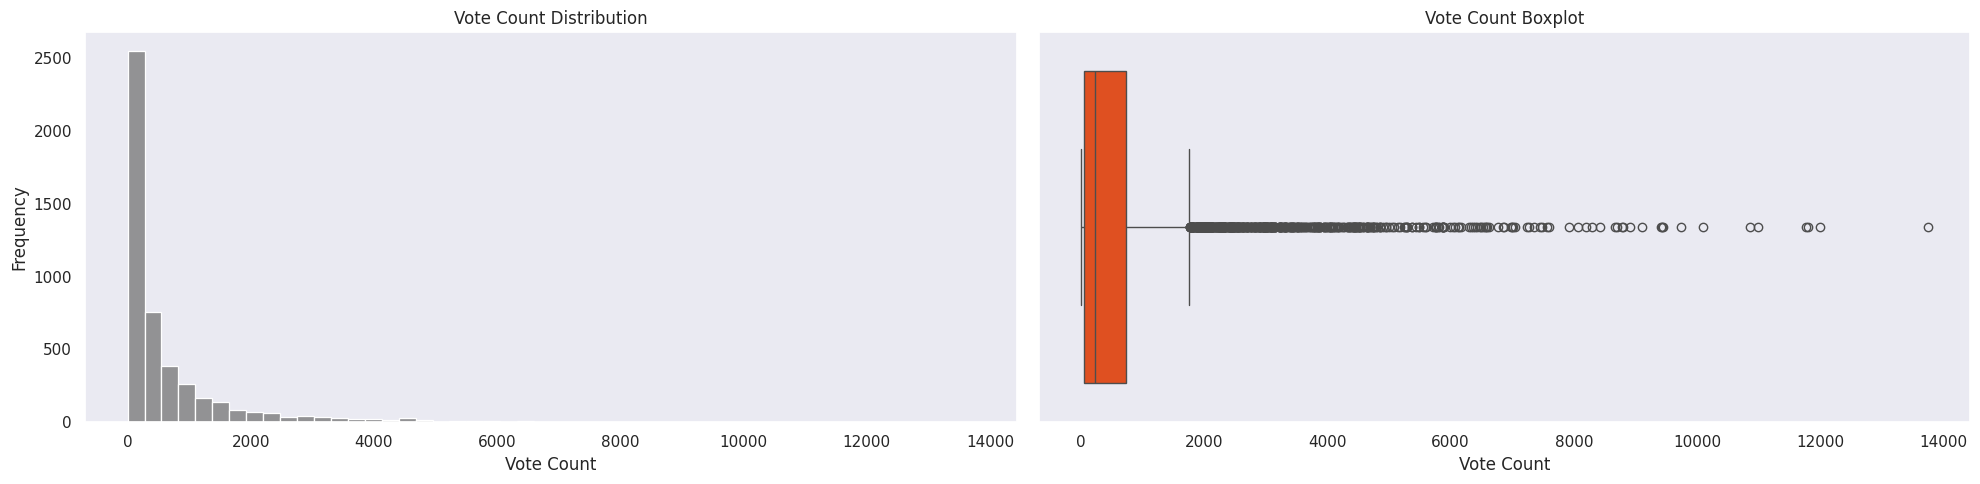

In [ ]:
# plot the vote count of each movies
sns.set(style="dark")

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

sns.histplot(df_combine2['vote_count'], bins=50, kde=False, color="#757575", ax=axes[0])
axes[0].set_title('Vote Count Distribution')
axes[0].set_xlabel('Vote Count')
axes[0].set_ylabel('Frequency')

sns.boxplot(x=df_combine2['vote_count'], color="#ff4001", ax=axes[1])
axes[1].set_title('Vote Count Boxplot')
axes[1].set_xlabel('Vote Count')

plt.tight_layout()

plt.show()


In [ ]:
def weighted_rating(x, m=m, C=C):
    v = x['vote_count']
    R = x['vote_average']
    # Calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C)

In [ ]:
# Define a new feature 'score' and calculate its value with `weighted_rating()`
df_combine2['score'] = df_combine2.apply(weighted_rating, axis=1)

In [ ]:
df_combine2

,movie_id,title_x,cast,crew,budget,genres,homepage,keywords,original_language,original_title,...,release_date,revenue,runtime,spoken_languages,status,tagline,title_y,vote_average,vote_count,score
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de...",237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,...,2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,7.190321
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de...",300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,...,2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,6.881752
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de...",245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,...,2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,6.295270
3,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de...",250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,...,2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,7.582973
4,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de...",260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,...,2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,6.099635
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4798,9367,El Mariachi,"[{""cast_id"": 1, ""character"": ""El Mariachi"", ""c...","[{""credit_id"": ""52fe44eec3a36847f80b280b"", ""de...",220000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",NaN,"[{""id"": 5616, ""name"": ""united states\u2013mexi...",es,El Mariachi,...,1992-09-04,2040920,81.0,"[{""iso_639_1"": ""es"", ""name"": ""Espa\u00f1ol""}]",Released,"He didn't come looking for trouble, but troubl...",El Mariachi,6.6,238,6.445573
4799,72766,Newlyweds,"[{""cast_id"": 1, ""character"": ""Buzzy"", ""credit_...","[{""credit_id"": ""52fe487dc3a368484e0fb013"", ""de...",9000,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 10749, ""...",NaN,[],en,Newlyweds,...,2011-12-26,0,85.0,[],Released,A newlywed couple's honeymoon is upended by th...,Newlyweds,5.9,5,6.083356
4800,231617,"Signed, Sealed, Delivered","[{""cast_id"": 8, ""character"": ""Oliver O\u2019To...","[{""credit_id"": ""52fe4df3c3a36847f8275ecf"", ""de...",0,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 18, ""nam...",http://www.hallmarkchannel.com/signedsealeddel...,"[{""id"": 248, ""name"": ""date""}, {""id"": 699, ""nam...",en,"Signed, Sealed, Delivered",...,2013-10-13,0,120.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,NaN,"Signed, Sealed

#### Data Merge

In [ ]:
df_merged = pd.merge(df_combined, df_combine2, left_on='title', right_on='original_title', how='left')

In [ ]:
df_merged

,userId,movieId,rating,timestamp,datetime,rating_month,rating_year,rating_hour,rating_weekday,rating_date,...,release_date,revenue,runtime,spoken_languages,status,tagline,title_y,vote_average,vote_count,score
0,1,16,4.0,1217897793,2008-08-05 00:56:33,8,2008,0,1,2008-08-05,...,1995-11-22,116112375.0,178.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,No one stays at the top forever.,Casino,7.8,1307.0,7.674122
1,1,24,1.5,1217895807,2008-08-05 00:23:27,8,2008,0,1,2008-08-05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,32,4.0,1217896246,2008-08-05 00:30:46,8,2008,0,1,2008-08-05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,47,4.0,1217896556,2008-08-05 00:35:56,8,2008,0,1,2008-08-05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,50,4.0,1217896523,2008-08-05 00:35:23,8,2008,0,1,2008-08-05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105554,668,142488,4.0,1451535844,2015-12-31 04:24:04,12,2015,4,3,2015-12-31,...,2015-11-06,88346473.0,128.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,Break the story. Break the silence.,Spotlight,7.8,2686.0,7.736339
105555,668,142507,3.5,1451535889,2015-12-31 04:24:49,12,2015,4,3,2015-12-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
105556,668,143385,4.0,1446388585,2015-11-01 14:36:25,11,2015,14,6,2015-11-01,...,2015-10-15,165478348.0,141.0,"[{""iso_639_1"": ""ru"", ""name"": ""P\u0443\u0441\u0...",Released,"In the shadow of war, one man showed the world...",Bridge of Spies,7.2,2583.0,7.157122
105557,668,144976,2.5,1448656898,2015-11-27 20:41:38,11,2015,20,4,2015-11-27,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_merged.drop(columns=['datetime','overview','tagline','keywords',
                        'genres','movie_id','title_x','homepage',
                        'original_title','title_y','status'], inplace=True)

In [ ]:
# remove the invalid id
df_merged['movieId'] = pd.to_numeric(df_merged['movieId'], errors='coerce')
df_merged = df_merged.dropna(subset=['movieId'])
df_merged['userId'] = pd.to_numeric(df_merged['userId'], errors='coerce')
df_merged = df_merged.dropna(subset=['userId'])

In [ ]:
# check the duplicate ratings
group_sizes = df_merged.groupby(['userId', 'movieId']).size()
multiple_ratings = group_sizes[group_sizes > 1]
multiple_ratings_df = multiple_ratings.reset_index

print(multiple_ratings_df)

<bound method Series.reset_index of userId  movieId
1       592        2
3       592        2
5       592        2
9       592        2
11      592        2
                  ..
653     592        2
654     592        2
656     592        2
660     592        2
668     592        2
Length: 220, dtype: int64>


In [ ]:
# delete the duplicate
df_merged = df_merged.drop_duplicates(subset=['userId', 'movieId'], keep='first')
# check is there anyother duplicates_answer should be false
print(df_merged.duplicated(subset=['userId', 'movieId']).any())

False


In [ ]:
df_merged['release_date'] = pd.to_datetime(df_merged['release_date'], errors='coerce')
df_merged['rating_date'] = pd.to_datetime(df_merged['rating_date'], errors='coerce')

df_merged['days_interval'] = (df_merged['rating_date'] - df_merged['release_date']).dt.days

In [ ]:
def safe_literal_eval(item):
    if isinstance(item, str):
        try:
            return literal_eval(item)
        except ValueError:
            return item
    return item

features = ['production_companies', 'production_countries', 'spoken_languages']
for feature in features:
    df_merged[feature] = df_merged[feature].apply(safe_literal_eval)


In [ ]:
def get_first_value_of_first_dict(feature_list):
    if isinstance(feature_list, list) and feature_list:
        first_dict = feature_list[0]
        if isinstance(first_dict, dict) and first_dict:
            first_value = next(iter(first_dict.values()))
            return first_value
    return None

for feature in features:
    df_merged[feature] = df_merged[feature].apply(get_first_value_of_first_dict)

In [ ]:
df_merged

,userId,movieId,rating,timestamp,rating_month,rating_year,rating_hour,rating_weekday,rating_date,title,...,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,vote_average,vote_count,score,days_interval
0,1,16,4.0,1217897793,8,2008,0,1,2008-08-05,Casino,...,Universal Pictures,FR,1995-11-22,116112375.0,178.0,en,7.8,1307.0,7.674122,4640.0
1,1,24,1.5,1217895807,8,2008,0,1,2008-08-05,Powder,...,None,None,NaT,NaN,NaN,None,NaN,NaN,NaN,NaN
2,1,32,4.0,1217896246,8,2008,0,1,2008-08-05,Twelve Monkeys (a.k.a. 12 Monkeys),...,None,None,NaT,NaN,NaN,None,NaN,NaN,NaN,NaN
3,1,47,4.0,1217896556,8,2008,0,1,2008-08-05,Seven (a.k.a. Se7en),...,None,None,NaT,NaN,NaN,None,NaN,NaN,NaN,NaN
4,1,50,4.0,1217896523,8,2008,0,1,2008-08-05,"Usual Suspects, The",...,None,None,NaT,NaN,NaN,None,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105554,668,142488,4.0,1451535844,12,2015,4,3,2015-12-31,Spotlight,...,Universal Pictures,CA,2015-11-06,88346473.0,128.0,en,7.8,2686.0,7.736339,55.0
105555,668,142507,3.5,1451535889,12,2015,4,3,2015-12-31,Pawn Sacrifice,...,None,None,NaT,NaN,NaN,None,NaN,NaN,NaN,NaN
105556,668,143385,4.0,1446388585,11,2015,14,6,2015-11-01,Bridge of Spies,...,DreamWorks SKG,IN,2015-10-15,165478348.0,141.0,ru,7.2,2583.0,7.157122,17.0
105557,668,144976,2.5,1448656898,11,2015,20,4,2015-11-27,Bone Tomahawk,...,None,None,NaT,NaN,NaN,None,NaN,NaN,NaN,NaN


In [ ]:
pip install torch

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [ ]:
import torch
import torch.nn as nn


In [ ]:
# standardlized
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

def create_index_mapping(column):
    return {key: idx for idx, key in enumerate(column.unique())}

scaler = StandardScaler()

language_mapping = create_index_mapping(df_merged['original_language'])
company_mapping = create_index_mapping(df_merged['production_companies'])
country_mapping = create_index_mapping(df_merged['production_countries'])
spoken_mapping = create_index_mapping(df_merged['spoken_languages'])

df_merged['language_idx'] = df_merged['original_language'].map(language_mapping)
df_merged['company_idx'] = df_merged['production_companies'].map(company_mapping)
df_merged['country_idx'] = df_merged['production_countries'].map(country_mapping)
df_merged['spoken_idx'] = df_merged['spoken_languages'].map(spoken_mapping)


df_merged['hour_sin'] = np.sin(2 * np.pi * df_merged['rating_hour'] / 24)
df_merged['hour_cos'] = np.cos(2 * np.pi * df_merged['rating_hour'] / 24)
df_merged['month_sin'] = np.sin(2 * np.pi * df_merged['rating_month']/ 12)
df_merged['month_cos'] = np.cos(2 * np.pi * df_merged['rating_month']/ 12)
df_merged['rating_weekday_sin'] = np.sin(2 * np.pi * df_merged['rating_weekday'] / 7)
df_merged['rating_weekday_cos'] = np.cos(2 * np.pi * df_merged['rating_weekday'] / 7)

continuous_features = ['budget', 'popularity', 'revenue', 'runtime', 'days_interval', 'score', 'vote_count']
df_merged[continuous_features] = scaler.fit_transform(df_merged[continuous_features])

In [ ]:
df_merged.drop(columns=['original_language','production_companies','production_countries','spoken_languages',
                        'rating_hour','rating_month','rating_year','launch_year','rating_weekday'
                        ], inplace=True)

In [ ]:
df_merged.drop(columns=['vote_average','rating_date','timestamp','cast','crew',
                        'release_date'], inplace=True)

In [ ]:
df_merged.rename(columns={'(no genres listed)': 'no_genres_listed'},inplace =True)

In [ ]:
df_merged.columns

Index(['userId', 'movieId', 'rating', 'title', 'no_genres_listed', 'Action',
       'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary',
       'Drama', 'Fantasy', 'Film_Noir', 'Horror', 'IMAX', 'Musical', 'Mystery',
       'Romance', 'Sci_Fi', 'Thriller', 'War', 'Western', 'budget',
       'popularity', 'revenue', 'runtime', 'vote_count', 'score',
       'days_interval', 'language_idx', 'company_idx', 'country_idx',
       'spoken_idx', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos',
       'rating_weekday_sin', 'rating_weekday_cos'],
      dtype='object')

In [ ]:
df_merged

,userId,movieId,rating,title,no_genres_listed,Action,Adventure,Animation,Children,Comedy,...,language_idx,company_idx,country_idx,spoken_idx,hour_sin,hour_cos,month_sin,month_cos,rating_weekday_sin,rating_weekday_cos
0,1,16,4.0,Casino,0,0,0,0,0,0,...,0,0,0,0,0.000000,1.000000,-8.660254e-01,-0.500000,0.781831,0.623490
1,1,24,1.5,Powder,0,0,0,0,0,0,...,1,1,1,1,0.000000,1.000000,-8.660254e-01,-0.500000,0.781831,0.623490
2,1,32,4.0,Twelve Monkeys (a.k.a. 12 Monkeys),0,0,0,0,0,0,...,1,1,1,1,0.000000,1.000000,-8.660254e-01,-0.500000,0.781831,0.623490
3,1,47,4.0,Seven (a.k.a. Se7en),0,0,0,0,0,0,...,1,1,1,1,0.000000,1.000000,-8.660254e-01,-0.500000,0.781831,0.623490
4,1,50,4.0,"Usual Suspects, The",0,0,0,0,0,0,...,1,1,1,1,0.000000,1.000000,-8.660254e-01,-0.500000,0.781831,0.623490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105554,668,142488,4.0,Spotlight,0,0,0,0,0,0,...,0,0,6,0,0.866025,0.500000,-2.449294e-16,1.000000,0.433884,-0.900969
105555,668,142507,3.5,Pawn Sacrifice,0,0,0,0,0,0,...,1,1,1,1,0.866025,0.500000,-2.449294e-16,1.000000,0.433884,-0.900969
105556,668,143385,4.0,Bridge of Spies,0,0,0,0,0,0,...,0,23,14,14,-0.500000,-0.866025,-5.000000e-01,0.866025,-0.781831,0.623490
105557,668,144976,2.5,Bone Tomahawk,0,0,0,0,0,0,...,1,1,1,1,-0.866025,0.500000,-5.000000e-01,0.866025,-0.433884,-0.900969


### Data sparsity

In [ ]:
combined_data = df_merged[['userId', 'movieId', 'rating']]

In [ ]:
cv = CrossValidation(
    data=combined_data.to_numpy(),
    k=5,
    rating_threshold=2.0,
    rating_scale=(combined_data['rating'].min(), combined_data['rating'].max()),
    seed=42,
    verbose=True
)

rating_threshold = 2.0
exclude_unknowns = True


In [ ]:
n_users = combined_data.userId.nunique()
n_items = combined_data.movieId.nunique()
n_ratings = len(combined_data)

rating_matrix_size = n_users * n_items
sparsity = 1 - n_ratings / rating_matrix_size

print(f"Number of users: {n_users}")
print(f"Number of items: {n_items}")
print(f"Number of available ratings: {n_ratings}")
print(f"Number of all possible ratings: {rating_matrix_size}")
print("-" * 40)
print(f"SPARSITY: {sparsity * 100.0:.2f}%"+'\n')

Number of users: 668
Number of items: 10325
Number of available ratings: 105339
Number of all possible ratings: 6897100
----------------------------------------
SPARSITY: 98.47%



### Data distribution

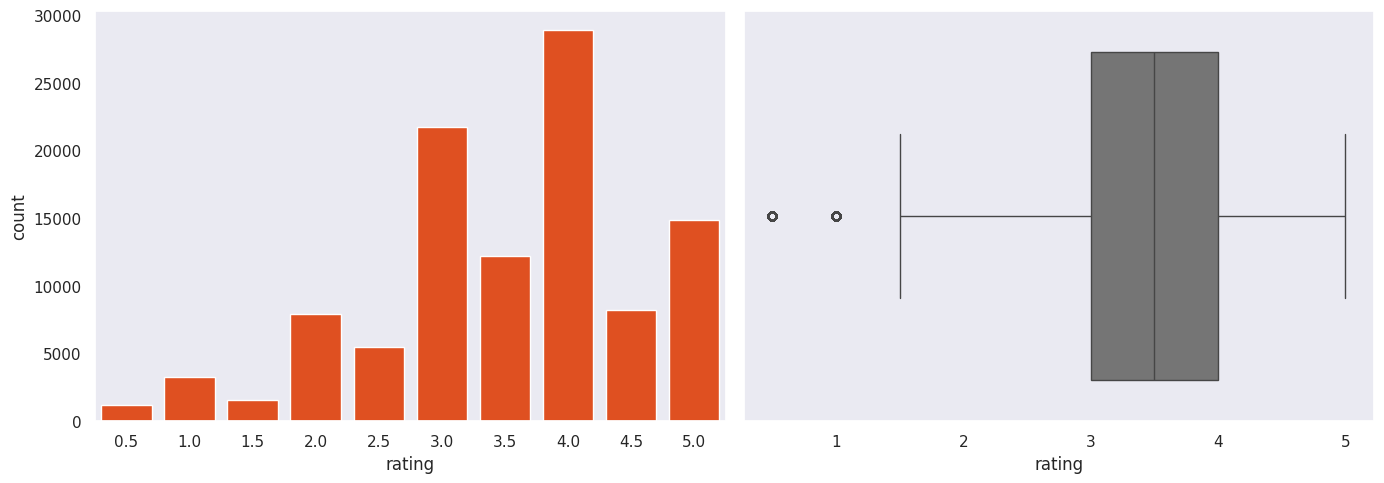

In [ ]:
sns.set_theme(style="dark")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

sns.countplot(x="rating", data=df_merged, color="#ff4001", ax=axes[0])

sns.boxplot(x="rating", data=df_merged, color="#757575", ax=axes[1])

plt.tight_layout()
plt.show()


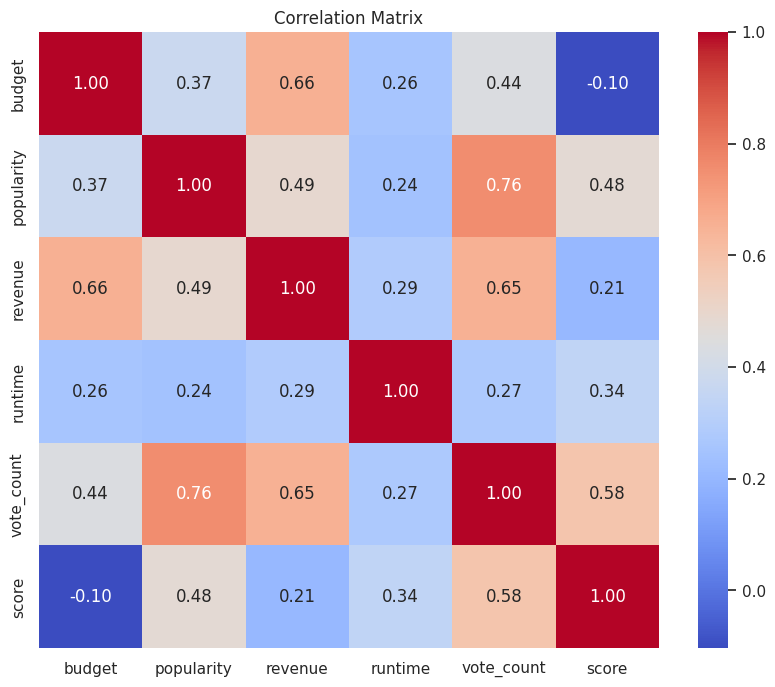

In [ ]:
correlation_matrix = df_merged[['budget', 'popularity', 'revenue', 'runtime', 'vote_count', 'score']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix')
plt.show()

In [ ]:
df_merged.drop(columns=['vote_count','popularity','revenue'], inplace=True)

## Data Split

In [ ]:
df_new = df_combined[['userId', 'title', 'rating']]

In [ ]:
cv = CrossValidation(
    data=df_new.to_numpy(),
    k=5,
    rating_threshold=3.5,
    rating_scale=(df_new['rating'].min(), df_new['rating'].max()),
    seed=42,
    verbose=True
)

rating_threshold = 3.5
exclude_unknowns = True


## Eval_metrics

In [ ]:
eval_metrics = [
    cornac.metrics.RMSE(),
    cornac.metrics.Precision(k=10),
    cornac.metrics.AUC(),
    cornac.metrics.Recall(k=10),
    cornac.metrics.FMeasure(k=10),
    cornac.metrics.NDCG(k=10),
    cornac.metrics.NCRR(k=10)
]

## Model Setup

In [ ]:
SEED = 42
VERBOSE = False

### MF

#### Full Data

In [ ]:
K=50
mf = MF(k=K, max_iter=20, learning_rate=0.01, lambda_reg=0.01, use_bias=True, verbose=VERBOSE, seed=SEED, name=f"MF(K={K},bias)")

In [ ]:
cornac.Experiment(
    eval_method=cv,
    models=[mf],
    metrics=eval_metrics,
    user_based=True,
).run()


Fold: 1


/usr/local/lib/python3.10/dist-packages/cornac/data/dataset.py:335: UserWarning: 322 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)
/usr/local/lib/python3.10/dist-packages/cornac/data/dataset.py:335: UserWarning: 14 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)


---
Training data:
Number of users = 668
Number of items = 9248
Number of ratings = 83949
Max rating = 5.0
Min rating = 0.5
Global mean = 3.5
---
Test data:
Number of users = 668
Number of items = 9248
Number of ratings = 20214
Number of unknown users = 0
Number of unknown items = 0
---
Validation data:
Number of users = 668
Number of items = 9248
Number of ratings = 20214
---
Total users = 668
Total items = 9248

[MF(K=50,bias)] Training started!

[MF(K=50,bias)] Evaluation started!


Rating:   0%|          | 0/20214 [00:00<?, ?it/s]

Ranking:   0%|          | 0/667 [00:00<?, ?it/s]

Fold: 2


/usr/local/lib/python3.10/dist-packages/cornac/data/dataset.py:335: UserWarning: 318 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)
/usr/local/lib/python3.10/dist-packages/cornac/data/dataset.py:335: UserWarning: 18 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)


---
Training data:
Number of users = 668
Number of items = 9253
Number of ratings = 83954
Max rating = 5.0
Min rating = 0.5
Global mean = 3.5
---
Test data:
Number of users = 668
Number of items = 9253
Number of ratings = 20226
Number of unknown users = 0
Number of unknown items = 0
---
Validation data:
Number of users = 668
Number of items = 9253
Number of ratings = 20226
---
Total users = 668
Total items = 9253

[MF(K=50,bias)] Training started!

[MF(K=50,bias)] Evaluation started!


Rating:   0%|          | 0/20226 [00:00<?, ?it/s]

Ranking:   0%|          | 0/667 [00:00<?, ?it/s]

Fold: 3


/usr/local/lib/python3.10/dist-packages/cornac/data/dataset.py:335: UserWarning: 305 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)


---
Training data:
Number of users = 668
Number of items = 9268
Number of ratings = 83966
Max rating = 5.0
Min rating = 0.5
Global mean = 3.5


/usr/local/lib/python3.10/dist-packages/cornac/data/dataset.py:335: UserWarning: 26 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)


---
Test data:
Number of users = 668
Number of items = 9268
Number of ratings = 20235
Number of unknown users = 0
Number of unknown items = 0
---
Validation data:
Number of users = 668
Number of items = 9268
Number of ratings = 20235
---
Total users = 668
Total items = 9268

[MF(K=50,bias)] Training started!

[MF(K=50,bias)] Evaluation started!


Rating:   0%|          | 0/20235 [00:00<?, ?it/s]

Ranking:   0%|          | 0/667 [00:00<?, ?it/s]

Fold: 4


/usr/local/lib/python3.10/dist-packages/cornac/data/dataset.py:335: UserWarning: 301 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)
/usr/local/lib/python3.10/dist-packages/cornac/data/dataset.py:335: UserWarning: 25 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)


---
Training data:
Number of users = 668
Number of items = 9271
Number of ratings = 83970
Max rating = 5.0
Min rating = 0.5
Global mean = 3.5
---
Test data:
Number of users = 668
Number of items = 9271
Number of ratings = 20242
Number of unknown users = 0
Number of unknown items = 0
---
Validation data:
Number of users = 668
Number of items = 9271
Number of ratings = 20242
---
Total users = 668
Total items = 9271

[MF(K=50,bias)] Training started!

[MF(K=50,bias)] Evaluation started!


Rating:   0%|          | 0/20242 [00:00<?, ?it/s]

Ranking:   0%|          | 0/667 [00:00<?, ?it/s]

Fold: 5


/usr/local/lib/python3.10/dist-packages/cornac/data/dataset.py:335: UserWarning: 298 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)
/usr/local/lib/python3.10/dist-packages/cornac/data/dataset.py:335: UserWarning: 15 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)


---
Training data:
Number of users = 668
Number of items = 9227
Number of ratings = 83973
Max rating = 5.0
Min rating = 0.5
Global mean = 3.5
---
Test data:
Number of users = 668
Number of items = 9227
Number of ratings = 20218
Number of unknown users = 0
Number of unknown items = 0
---
Validation data:
Number of users = 668
Number of items = 9227
Number of ratings = 20218
---
Total users = 668
Total items = 9227

[MF(K=50,bias)] Training started!

[MF(K=50,bias)] Evaluation started!


Rating:   0%|          | 0/20218 [00:00<?, ?it/s]

Ranking:   0%|          | 0/668 [00:00<?, ?it/s]


TEST:
...
[MF(K=50,bias)]
       |   RMSE |    AUC |  F1@10 | NCRR@10 | NDCG@10 | Precision@10 | Recall@10 | Train (s) | Test (s)
------ + ------ + ------ + ------ + ------- + ------- + ------------ + --------- + --------- + --------
Fold 0 | 0.8454 | 0.7298 | 0.0208 |  0.0446 |  0.0432 |       0.0373 |    0.0216 |    0.3255 |  10.1807
Fold 1 | 0.8513 | 0.7283 | 0.0219 |  0.0447 |  0.0454 |       0.0387 |    0.0253 |    0.2318 |   8.6664
Fold 2 | 0.8520 | 0.7309 | 0.0179 |  0.0394 |  0.0384 |       0.0347 |    0.0173 |    0.6793 |   7.9724
Fold 3 | 0.8667 | 0.7324 | 0.0220 |  0.0442 |  0.0451 |       0.0416 |    0.0226 |    0.3687 |   8.1300
Fold 4 | 0.8449 | 0.7248 | 0.0161 |  0.0321 |  0.0325 |       0.0292 |    0.0178 |    0.1414 |   2.1847
------ + ------ + ------ + ------ + ------- + ------- + ------------ + --------- + --------- + --------
Mean   | 0.8521 | 0.7292 | 0.0197 |  0.0410 |  0.0409 |       0.0363 |    0.0209 |    0.3493 |   7.4268
Std    | 0.0079 | 0.0026 | 0.0024 |  

#### Filtered data(used to compared with FM and CTR)

In [ ]:
matched_df_merged = df_merged[df_merged['title'].isin(df_text['original_title'])]

In [ ]:
cv_filtered = CrossValidation(
    data=matched_df_merged.to_numpy(),
    k=5,
    rating_threshold=3.5,
    rating_scale=(df_new['rating'].min(), df_new['rating'].max()),
    seed=42,
    verbose=True
)

rating_threshold = 3.5
exclude_unknowns = True


In [ ]:
cornac.Experiment(
    eval_method=cv_filtered,
    models=[mf],
    metrics=eval_metrics,
    user_based=True,
).run()


Fold: 1
---
Training data:
Number of users = 667
Number of items = 2649
Number of ratings = 40664
Max rating = 5.0
Min rating = 0.5
Global mean = 3.5
---
Test data:
Number of users = 667
Number of items = 2649
Number of ratings = 10051
Number of unknown users = 0
Number of unknown items = 0
---
Validation data:
Number of users = 667
Number of items = 2649
Number of ratings = 10051
---
Total users = 667
Total items = 2649

[MF(K=50,bias)] Training started!

[MF(K=50,bias)] Evaluation started!


Rating:   0%|          | 0/10051 [00:00<?, ?it/s]

Ranking:   0%|          | 0/656 [00:00<?, ?it/s]

Fold: 2
---
Training data:
Number of users = 667
Number of items = 2656
Number of ratings = 40661
Max rating = 5.0
Min rating = 0.5
Global mean = 3.5
---
Test data:
Number of users = 667
Number of items = 2656
Number of ratings = 10059
Number of unknown users = 0
Number of unknown items = 0
---
Validation data:
Number of users = 667
Number of items = 2656
Number of ratings = 10059
---
Total users = 667
Total items = 2656

[MF(K=50,bias)] Training started!

[MF(K=50,bias)] Evaluation started!


Rating:   0%|          | 0/10059 [00:00<?, ?it/s]

Ranking:   0%|          | 0/659 [00:00<?, ?it/s]

Fold: 3
---
Training data:
Number of users = 667
Number of items = 2634
Number of ratings = 40664
Max rating = 5.0
Min rating = 0.5
Global mean = 3.5
---
Test data:
Number of users = 667
Number of items = 2634
Number of ratings = 10040
Number of unknown users = 0
Number of unknown items = 0
---
Validation data:
Number of users = 667
Number of items = 2634
Number of ratings = 10040
---
Total users = 667
Total items = 2634

[MF(K=50,bias)] Training started!

[MF(K=50,bias)] Evaluation started!


Rating:   0%|          | 0/10040 [00:00<?, ?it/s]

Ranking:   0%|          | 0/655 [00:00<?, ?it/s]

Fold: 4
---
Training data:
Number of users = 667
Number of items = 2647
Number of ratings = 40664
Max rating = 5.0
Min rating = 0.5
Global mean = 3.5
---
Test data:
Number of users = 667
Number of items = 2647
Number of ratings = 10053
Number of unknown users = 0
Number of unknown items = 0
---
Validation data:
Number of users = 667
Number of items = 2647
Number of ratings = 10053
---
Total users = 667
Total items = 2647

[MF(K=50,bias)] Training started!

[MF(K=50,bias)] Evaluation started!


Rating:   0%|          | 0/10053 [00:00<?, ?it/s]

Ranking:   0%|          | 0/658 [00:00<?, ?it/s]

Fold: 5
---
Training data:
Number of users = 667
Number of items = 2650
Number of ratings = 40663
Max rating = 5.0
Min rating = 0.5
Global mean = 3.5
---
Test data:
Number of users = 667
Number of items = 2650
Number of ratings = 10049
Number of unknown users = 0
Number of unknown items = 0
---
Validation data:
Number of users = 667
Number of items = 2650
Number of ratings = 10049
---
Total users = 667
Total items = 2650

[MF(K=50,bias)] Training started!

[MF(K=50,bias)] Evaluation started!


Rating:   0%|          | 0/10049 [00:00<?, ?it/s]

Ranking:   0%|          | 0/656 [00:00<?, ?it/s]


TEST:
...
[MF(K=50,bias)]
       |   RMSE |    AUC |  F1@10 | NCRR@10 | NDCG@10 | Recall@10 | Train (s) | Test (s)
------ + ------ + ------ + ------ + ------- + ------- + --------- + --------- + --------
Fold 0 | 0.8524 | 0.7399 | 0.0285 |  0.0606 |  0.0558 |    0.0401 |    0.1546 |   8.6341
Fold 1 | 0.8342 | 0.7252 | 0.0249 |  0.0382 |  0.0407 |    0.0384 |    0.1127 |   1.8987
Fold 2 | 0.8402 | 0.7340 | 0.0266 |  0.0374 |  0.0410 |    0.0372 |    0.0694 |   1.4525
Fold 3 | 0.8334 | 0.7350 | 0.0190 |  0.0386 |  0.0354 |    0.0253 |    0.0661 |   1.4585
Fold 4 | 0.8386 | 0.7351 | 0.0278 |  0.0501 |  0.0486 |    0.0387 |    0.0696 |   1.5114
------ + ------ + ------ + ------ + ------- + ------- + --------- + --------- + --------
Mean   | 0.8397 | 0.7338 | 0.0254 |  0.0450 |  0.0443 |    0.0359 |    0.0945 |   2.9910
Std    | 0.0068 | 0.0048 | 0.0034 |  0.0091 |  0.0071 |    0.0054 |    0.0347 |   2.8264



### Content Based

In [ ]:
df_overview = df_tmdb_movies[['overview']].fillna('')

vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(df_overview['overview'])

print("Shape of TF-IDF Matrix:", tfidf_matrix.shape)
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
indices = pd.Series(df_tmdb_movies.index, index=df_tmdb_movies['title']).drop_duplicates()

def get_recommendations(title, cosine_sim=cosine_sim):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    movie_indices = [i[0] for i in sim_scores[1:11]]
    return df_tmdb_movies['title'].iloc[movie_indices]

print(get_recommendations('Batman Forever'))

Shape of TF-IDF Matrix: (4803, 20978)
3                         The Dark Knight Rises
119                               Batman Begins
65                              The Dark Knight
428                              Batman Returns
210                              Batman & Robin
3854    Batman: The Dark Knight Returns, Part 2
1359                                     Batman
4343                                   Cry_Wolf
174                         The Incredible Hulk
9            Batman v Superman: Dawn of Justice
Name: title, dtype: object


### WMF

In [ ]:
K=50
wmf = WMF(k=K, max_iter=100, a=1.0, b=0.01, learning_rate=0.001, lambda_u=0.01, lambda_v=0.01,
          verbose=VERBOSE, seed=SEED, name=f"WMF(K={K})")

In [ ]:
cornac.Experiment(
    eval_method=cv,
    models=[wmf],
    metrics=eval_metrics,
    user_based=True,
).run()



TEST:
...
[WMF(K=50)]
       |   RMSE |    AUC |  F1@10 | NCRR@10 | NDCG@10 | Precision@10 | Recall@10 | Train (s) | Test (s)
------ + ------ + ------ + ------ + ------- + ------- + ------------ + --------- + --------- + --------
Fold 0 | 1.4170 | 0.9192 | 0.1220 |  0.1914 |  0.2017 |       0.1269 |    0.2017 |   10.3581 |   1.3360
Fold 1 | 1.4047 | 0.9222 | 0.1220 |  0.1811 |  0.1920 |       0.1263 |    0.1964 |    9.0257 |   2.6547
Fold 2 | 1.4368 | 0.9174 | 0.1180 |  0.1860 |  0.1952 |       0.1221 |    0.1906 |    8.2148 |   1.4403
Fold 3 | 1.4246 | 0.9213 | 0.1236 |  0.1978 |  0.2041 |       0.1294 |    0.1971 |    9.5725 |   1.3507
Fold 4 | 1.4309 | 0.9207 | 0.1129 |  0.1762 |  0.1823 |       0.1206 |    0.1779 |   10.0966 |   1.3116
------ + ------ + ------ + ------ + ------- + ------- + ------------ + --------- + --------- + --------
Mean   | 1.4228 | 0.9201 | 0.1197 |  0.1865 |  0.1951 |       0.1251 |    0.1927 |    9.4535 |   1.6186
Std    | 0.0112 | 0.0017 | 0.0039 |  0.00

### NCF


In [ ]:
#提取出userId, movieId, rating, 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'
#等数十个列来使用
from cornac.data import GraphModality

rating_data = list(zip(df_combined['userId'], df_combined['movieId'], df_combined['rating']))


# 准备特征数据
movie_feature_data = df_combined[['movieId', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film_Noir', 'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci_Fi', 'Thriller', 'War', 'Western']]

# 转换物品特征数据为三列格式
movie_features_list = []
for row in movie_feature_data.itertuples(index=False):
    movie_id = row[0]
    for i, val in enumerate(row[1:], start=1):
        movie_features_list.append([movie_id, i, val])
movie_feature_data_formatted = pd.DataFrame(movie_features_list, columns=['movieId', 'featureId', 'featureValue'])


# 创建特征的GraphModality
movie_graph = GraphModality(data=movie_feature_data_formatted.values, weighted=True)


# 数据分割
ratio_split = RatioSplit(
    data=rating_data, test_size=0.2, rating_threshold=3.5,
    exclude_unknowns=True, verbose=True, item_graph=movie_graph
)

rating_threshold = 3.5
exclude_unknowns = True
---
Training data:
Number of users = 668
Number of items = 9576
Number of ratings = 84271
Max rating = 5.0
Min rating = 0.5
Global mean = 3.5
---
Test data:
Number of users = 668
Number of items = 9576
Number of ratings = 20239
Number of unknown users = 0
Number of unknown items = 0
---
Total users = 668
Total items = 9576


In [ ]:
import pandas as pd
from cornac.data import GraphModality
from cornac.eval_methods import RatioSplit
from cornac.models import NeuMF
from cornac.metrics import RMSE, MAE, Precision, Recall
from cornac import Experiment

# 定义NeuMF模型
ncf = NeuMF(
    num_factors=8,
    layers=[16, 8, 4],
    act_fn='relu',
    num_epochs=20,
    batch_size=256,
    lr=0.001,
    verbose=True
)

In [ ]:
experiment = Experiment(
    eval_method=cv,
    models=[ncf],
    metrics=eval_metrics
)
experiment.run()

Fold: 1


/usr/local/lib/python3.10/dist-packages/cornac/data/dataset.py:335: UserWarning: 322 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)
/usr/local/lib/python3.10/dist-packages/cornac/data/dataset.py:335: UserWarning: 14 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)


---
Training data:
Number of users = 668
Number of items = 9248
Number of ratings = 83949
Max rating = 5.0
Min rating = 0.5
Global mean = 3.5
---
Test data:
Number of users = 668
Number of items = 9248
Number of ratings = 20214
Number of unknown users = 0
Number of unknown items = 0
---
Validation data:
Number of users = 668
Number of items = 9248
Number of ratings = 20214
---
Total users = 668
Total items = 9248

[NeuMF] Training started!


  0%|          | 0/20 [00:00<?, ?it/s]


[NeuMF] Evaluation started!


Rating:   0%|          | 0/20214 [00:00<?, ?it/s]

Ranking:   0%|          | 0/667 [00:00<?, ?it/s]

Fold: 2
---
Training data:
Number of users = 668
Number of items = 9253
Number of ratings = 83954
Max rating = 5.0
Min rating = 0.5
Global mean = 3.5
---
Test data:
Number of users = 668
Number of items = 9253
Number of ratings = 20226
Number of unknown users = 0
Number of unknown items = 0
---
Validation data:
Number of users = 668
Number of items = 9253
Number of ratings = 20226
---
Total users = 668
Total items = 9253

[NeuMF] Training started!


  0%|          | 0/20 [00:00<?, ?it/s]


[NeuMF] Evaluation started!


Rating:   0%|          | 0/20226 [00:00<?, ?it/s]

Ranking:   0%|          | 0/667 [00:00<?, ?it/s]

Fold: 3
---
Training data:
Number of users = 668
Number of items = 9268
Number of ratings = 83966
Max rating = 5.0
Min rating = 0.5
Global mean = 3.5
---
Test data:
Number of users = 668
Number of items = 9268
Number of ratings = 20235
Number of unknown users = 0
Number of unknown items = 0
---
Validation data:
Number of users = 668
Number of items = 9268
Number of ratings = 20235
---
Total users = 668
Total items = 9268

[NeuMF] Training started!


  0%|          | 0/20 [00:00<?, ?it/s]


[NeuMF] Evaluation started!


Rating:   0%|          | 0/20235 [00:00<?, ?it/s]

Ranking:   0%|          | 0/667 [00:00<?, ?it/s]

Fold: 4
---
Training data:
Number of users = 668
Number of items = 9271
Number of ratings = 83970
Max rating = 5.0
Min rating = 0.5
Global mean = 3.5
---
Test data:
Number of users = 668
Number of items = 9271
Number of ratings = 20242
Number of unknown users = 0
Number of unknown items = 0
---
Validation data:
Number of users = 668
Number of items = 9271
Number of ratings = 20242
---
Total users = 668
Total items = 9271

[NeuMF] Training started!


  0%|          | 0/20 [00:00<?, ?it/s]


[NeuMF] Evaluation started!


Rating:   0%|          | 0/20242 [00:00<?, ?it/s]

Ranking:   0%|          | 0/667 [00:00<?, ?it/s]

Fold: 5
---
Training data:
Number of users = 668
Number of items = 9227
Number of ratings = 83973
Max rating = 5.0
Min rating = 0.5
Global mean = 3.5
---
Test data:
Number of users = 668
Number of items = 9227
Number of ratings = 20218
Number of unknown users = 0
Number of unknown items = 0
---
Validation data:
Number of users = 668
Number of items = 9227
Number of ratings = 20218
---
Total users = 668
Total items = 9227

[NeuMF] Training started!


  0%|          | 0/20 [00:00<?, ?it/s]


[NeuMF] Evaluation started!


Rating:   0%|          | 0/20218 [00:00<?, ?it/s]

Ranking:   0%|          | 0/668 [00:00<?, ?it/s]


TEST:
...
[NeuMF]
       |   RMSE |    AUC |  F1@10 | NCRR@10 | NDCG@10 | Precision@10 | Recall@10 | Train (s) | Test (s)
------ + ------ + ------ + ------ + ------- + ------- + ------------ + --------- + --------- + --------
Fold 0 | 3.0754 | 0.9375 | 0.0779 |  0.1297 |  0.1314 |       0.1084 |    0.0913 |  159.7807 |  16.5562
Fold 1 | 3.1055 | 0.9364 | 0.0800 |  0.1295 |  0.1320 |       0.1079 |    0.0970 |  148.8261 |  15.6131
Fold 2 | 3.0891 | 0.9395 | 0.0878 |  0.1444 |  0.1489 |       0.1253 |    0.1025 |  156.6467 |  16.0023
Fold 3 | 3.0862 | 0.9394 | 0.0892 |  0.1458 |  0.1480 |       0.1222 |    0.1063 |  152.3996 |  15.6278
Fold 4 | 3.1094 | 0.9375 | 0.0867 |  0.1515 |  0.1526 |       0.1242 |    0.1030 |  149.0945 |  15.8934
------ + ------ + ------ + ------ + ------- + ------- + ------------ + --------- + --------- + --------
Mean   | 3.0931 | 0.9381 | 0.0843 |  0.1402 |  0.1426 |       0.1176 |    0.1000 |  153.3495 |  15.9386
Std    | 0.0126 | 0.0012 | 0.0045 |  0.0090 |

### CTR

In [ ]:
df_text.columns

Index(['movie_id', 'original_title', 'cast', 'keywords', 'genres',
       'production_companies', 'director'],
      dtype='object')

In [ ]:
df_new.columns

Index(['userId', 'title', 'rating'], dtype='object')

In [ ]:
matched_df_text = df_text[df_text['original_title'].isin(df_new['title'])]
updated_df_new = df_new[df_new['title'].isin(matched_df_text['original_title'])]

In [ ]:
updated_df_new

,userId,title,rating
0,1,Casino,4.0
5,1,Braveheart,4.0
6,1,Apollo 13,3.0
7,1,Crimson Tide,4.0
8,1,Die Hard: With a Vengeance,3.0
...,...,...,...
105326,668,Spectre,4.0
105330,668,Sicario,4.0
105334,668,Spotlight,4.0
105336,668,Bridge of Spies,4.0


In [ ]:
def combine_columns(row):
    combined = []
    for column in ['cast', 'keywords', 'genres', 'production_companies', 'director']:
        if isinstance(row[column], list):
            combined.extend(row[column])
        else:
            combined.append(row[column])
    return combined

matched_df_text['combined'] = matched_df_text.apply(combine_columns, axis=1)

<ipython-input-118-ba68bce40cef>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_df_text['combined'] = matched_df_text.apply(combine_columns, axis=1)


In [ ]:
matched_df_text[['original_title', 'combined']]

,original_title,combined
0,Four Rooms,"[Tim Roth, Antonio Banderas, Jennifer Beals, h..."
2,Finding Nemo,"[Albert Brooks, Ellen DeGeneres, Alexander Gou..."
3,Forrest Gump,"[Tom Hanks, Robin Wright, Gary Sinise, vietnam..."
4,American Beauty,"[Kevin Spacey, Annette Bening, Thora Birch, ma..."
5,Dancer in the Dark,"[Björk, Catherine Deneuve, David Morse, indivi..."
...,...,...
4720,Circle,"[Julie Benz, Carter Jenkins, Cesar Garcia, sur..."
4722,Heist,"[Jeffrey Dean Morgan, Robert De Niro, Kate Bos..."
4749,Abandoned,"[Dominic Purcell, Peter Feeney, Owen Black, su..."
4793,Restoration,"[Emily Roya O'Brien, Adrian Gaeta, Zack Ward, ..."


In [ ]:
triplet_data = [tuple(x) for x in updated_df_new[['userId', 'title', 'rating']].values.tolist()]

In [ ]:

matched_df_text['combined'] = matched_df_text['combined'].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)
combined_list = matched_df_text['combined'].tolist()

<ipython-input-121-0a27da69a13f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_df_text['combined'] = matched_df_text['combined'].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)


In [ ]:
combined_list[:5]

["Tim Roth, Antonio Banderas, Jennifer Beals, hotel, new year's eve, witch, Crime, Comedy, Miramax Films, A Band Apart, Allison Anders",
 'Albert Brooks, Ellen DeGeneres, Alexander Gould, father son relationship, harbor, underwater, Animation, Family, Pixar Animation Studios, Andrew Stanton',
 'Tom Hanks, Robin Wright, Gary Sinise, vietnam veteran, hippie, mentally disabled, Comedy, Drama, Romance, Paramount Pictures, Robert Zemeckis',
 'Kevin Spacey, Annette Bening, Thora Birch, male nudity, female nudity, adultery, Drama, DreamWorks SKG, Jinks/Cohen Company, Sam Mendes',
 'Björk, Catherine Deneuve, David Morse, individual, dancing, usa, Drama, Crime, Music, Fine Line Features, Zentropa Entertainments, Danmarks Radio (DR), Lars von Trier']

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
K = 20
ctr = CTR(k=K, max_iter=50, a=1.0, b=0.01, lambda_u=0.01, lambda_v=0.01, verbose=VERBOSE, seed=SEED)
wmf = WMF(k=K, max_iter=50, a=1.0, b=0.01, learning_rate=0.005, lambda_u=0.01, lambda_v=0.01,
          verbose=VERBOSE,seed=SEED)

item_text_modality = TextModality(
    corpus=combined_list,
    ids=matched_df_text['original_title'].tolist(),
    tokenizer=BaseTokenizer(sep=" ", stop_words="english"),
    max_vocab=8000,
    max_doc_freq=0.5,
)

In [ ]:
print(type(matched_df_text['combined'].tolist()))
print(type(matched_df_text['original_title'].tolist()))
print(type(triplet_data))
print(type(item_text_modality))

<class 'list'>
<class 'list'>
<class 'list'>
<class 'cornac.data.text.TextModality'>


In [ ]:
cv = CrossValidation(
    data=triplet_data,
    k=5,
    rating_threshold=3.5,
    item_text=item_text_modality,
    seed=SEED,
    verbose=VERBOSE
)

In [ ]:
print(f"Length of corpus: {len(item_text_modality.corpus)}")
unique_items = set(triplet[1] for triplet in triplet_data)
print(f"Number of unique items in triplet_data: {len(unique_items)}")

Length of corpus: 2608
Number of unique items in triplet_data: 2607


In [ ]:
cornac.Experiment(eval_method=cv, models=[ctr, wmf], metrics=eval_metrics).run()


TEST:
...
[CTR]
       |   RMSE |    AUC |  F1@10 | NCRR@10 | NDCG@10 | Precision@10 | Recall@10 | Train (s) | Test (s)
------ + ------ + ------ + ------ + ------- + ------- + ------------ + --------- + --------- + --------
Fold 0 | 1.6308 | 0.8977 | 0.1014 |  0.1404 |  0.1583 |       0.0990 |    0.1792 |   58.8296 |   1.3332
Fold 1 | 1.6410 | 0.8927 | 0.1008 |  0.1479 |  0.1577 |       0.0990 |    0.1640 |   56.4999 |   2.6993
Fold 2 | 1.6533 | 0.8920 | 0.1052 |  0.1467 |  0.1617 |       0.1033 |    0.1756 |   54.8217 |   1.3331
Fold 3 | 1.6565 | 0.8938 | 0.0986 |  0.1385 |  0.1535 |       0.0984 |    0.1675 |   61.2920 |   1.3520
Fold 4 | 1.6752 | 0.8926 | 0.0971 |  0.1367 |  0.1487 |       0.0958 |    0.1636 |   58.7610 |   1.3119
------ + ------ + ------ + ------ + ------- + ------- + ------------ + --------- + --------- + --------
Mean   | 1.6514 | 0.8937 | 0.1006 |  0.1420 |  0.1560 |       0.0991 |    0.1700 |   58.0408 |   1.6059
Std    | 0.0150 | 0.0020 | 0.0028 |  0.0045 |  

### FM

#### FM on filtered data

In [ ]:
from collections import defaultdict

# create idx for user and movie
user_id2idx = {uid: idx for idx, uid in enumerate(sorted(matched_df_merged['userId'].unique()))}
movie_id2idx = {mid: idx for idx, mid in enumerate(sorted(matched_df_merged['movieId'].unique()))}
n_users = len(user_id2idx)
n_movies = len(movie_id2idx)

genres = ['no_genres_listed','Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film_Noir', 'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci_Fi', 'Thriller', 'War', 'Western']
other_features = ['budget', 'runtime', 'score', 'days_interval', 'language_idx', 'company_idx', 'country_idx', 'spoken_idx', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos','rating_weekday_sin', 'rating_weekday_cos']


feature_start_idx = defaultdict(int)
current_idx = n_users + n_movies
for genre in genres + other_features:
    feature_start_idx[genre] = current_idx
    current_idx += 1

def to_fm_sparse_fmt(rating, uid, mid, features):
    feature_strs = []
    # Formatting user and movie indices
    user_idx = user_id2idx[uid]
    movie_idx = movie_id2idx[mid] + n_users

    # Adding genre features only if they are present
    for genre in genres:
        if genre in features:
            feature_strs.append(f"{feature_start_idx[genre]}:1")

    # Adding other features only if they are present and not None
    for feature in other_features:
        if feature in features and features[feature] is not None:
            feature_strs.append(f"{feature_start_idx[feature]}:{features[feature]}")

    # Construct the final feature string
    return f"{rating} {user_idx}:1 {movie_idx}:1 {' '.join(feature_strs)}\n"

def save_data(df, filepath):
    with open(filepath, "w") as f:
        for row in df.itertuples(index=False):
            # Assuming `features` is a dict containing all non-ID, non-rating attributes
            features = {attr: getattr(row, attr) for attr in df.columns if attr not in ['userId', 'movieId', 'rating']}
            f.write(to_fm_sparse_fmt(row.rating, row.userId, row.movieId, features))


In [ ]:
save_data(matched_df_merged, "/content/drive/MyDrive/SMU_MITB_RS/GrpProject/filtered_data.libfm")

In [ ]:
!head /content/drive/MyDrive/SMU_MITB_RS/GrpProject/filtered_data.libfm

4.0 0:1 671:1 3413:1 3414:1 3415:1 3416:1 3417:1 3418:1 3419:1 3420:1 3421:1 3422:1 3423:1 3424:1 3425:1 3426:1 3427:1 3428:1 3429:1 3430:1 3431:1 3432:1 3433:0.1325369370260916 3434:2.565159876425636 3435:1.2594724772165053 3436:0.2403690343426394 3437:0 3438:0 3439:0 3440:0 3441:0.0 3442:1.0 3443:-0.8660254037844384 3444:-0.5000000000000004 3445:0.7818314824680298 3446:0.6234898018587336
4.0 0:1 702:1 3413:1 3414:1 3415:1 3416:1 3417:1 3418:1 3419:1 3420:1 3421:1 3422:1 3423:1 3424:1 3425:1 3426:1 3427:1 3428:1 3429:1 3430:1 3431:1 3432:1 3433:0.557611461439853 3434:2.522721947200318 3435:1.2280360395009373 3436:0.283017279451443 3437:0 3438:2 3439:2 3440:0 3441:0.0 3442:1.0 3443:-0.8660254037844384 3444:-0.5000000000000004 3445:0.7818314824680298 3446:0.6234898018587336
3.0 0:1 708:1 3413:1 3414:1 3415:1 3416:1 3417:1 3418:1 3419:1 3420:1 3421:1 3422:1 3423:1 3424:1 3425:1 3426:1 3427:1 3428:1 3429:1 3430:1 3431:1 3432:1 3433:0.1325369370260916 3434:0.9525185658635631 3435:0.6400496

In [ ]:


df_filtered = pd.read_csv('/content/drive/MyDrive/SMU_MITB_RS/GrpProject/filtered_data.libfm', header=None, sep=' ')

kf = KFold(n_splits=5, shuffle=True, random_state=42)

libfm_path = './libfm/bin/libFM'
rmse_list = []

fold = 0
for train_index, test_index in kf.split(df_filtered):
    train_df = df_filtered.iloc[train_index]
    test_df = df_filtered.iloc[test_index]
    train_file = f'train_fold{fold}.libfm'
    test_file = f'test_fold{fold}.libfm'

    train_df.to_csv(train_file, index=False, header=False, sep=' ')
    test_df.to_csv(test_file, index=False, header=False, sep=' ')


    command = [
        libfm_path,
        '-task', 'r',
        '-train', train_file,
        '-test', test_file,
        '-seed', '42',
        '-dim', '1,1,150',
        '-iter', '400',
        '-learn_rate', '0.8',
        '-regular', '0.01,0.01,0.01'
    ]

    result = subprocess.run(command, capture_output=True, text=True)
    test_rmse = re.findall(r"Test=([\d\.]+)", result.stdout)
    if test_rmse:
        rmse_list.append(float(test_rmse[-1]))

    print(f"Output for fold {fold}:\n{result.stdout}")

    fold += 1

Output for fold 0:
----------------------------------------------------------------------------
libFM
  Version: 1.4.4
  Author:  Steffen Rendle, srendle@libfm.org
  WWW:     http://www.libfm.org/
This program comes with ABSOLUTELY NO WARRANTY; for details see license.txt.
This is free software, and you are welcome to redistribute it under certain
conditions; for details see license.txt.
----------------------------------------------------------------------------
Loading train...	
has x = 0
has xt = 1
num_rows=40663	num_values=1463868	num_features=3447	min_target=0.5	max_target=5
Loading test... 	
has x = 0
has xt = 1
num_rows=10166	num_values=365976	num_features=3447	min_target=0.5	max_target=5
#relations: 0
Loading meta data...	
#Iter=  0	Train=2.15898	Test=2.15154
#Iter=  1	Train=1.68861	Test=1.55682
#Iter=  2	Train=1.21711	Test=1.31236
#Iter=  3	Train=1.02365	Test=1.192
#Iter=  4	Train=0.948844	Test=1.12675
#Iter=  5	Train=0.910679	Test=1.08582
#Iter=  6	Train=0.887621	Test=1.05688

In [ ]:
macro_rmse = np.mean(rmse_list)
print(f"Macro RMSE across all folds: {macro_rmse}")

Macro RMSE across all folds: 0.8876517999999999


#### FM on full Data

In [ ]:
from collections import defaultdict

# create idx for user and movie
user_id2idx = {uid: idx for idx, uid in enumerate(sorted(df_merged['userId'].unique()))}
movie_id2idx = {mid: idx for idx, mid in enumerate(sorted(df_merged['movieId'].unique()))}
n_users = len(user_id2idx)
n_movies = len(movie_id2idx)

genres = ['no_genres_listed','Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film_Noir', 'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci_Fi', 'Thriller', 'War', 'Western']
other_features = ['budget', 'runtime', 'score', 'days_interval', 'language_idx', 'company_idx', 'country_idx', 'spoken_idx', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos','rating_weekday_sin', 'rating_weekday_cos']

feature_start_idx = defaultdict(int)
current_idx = n_users + n_movies
for genre in genres + other_features:
    feature_start_idx[genre] = current_idx
    current_idx += 1

def to_fm_sparse_fmt(rating, uid, mid, features):
    feature_strs = []
    # Formatting user and movie indices
    user_idx = user_id2idx[uid]
    movie_idx = movie_id2idx[mid] + n_users

    # Adding genre features only if they are present
    for genre in genres:
        if genre in features:
            feature_strs.append(f"{feature_start_idx[genre]}:1")

    # Adding other features only if they are present and not None
    for feature in other_features:
        if feature in features and features[feature] is not None:
            feature_strs.append(f"{feature_start_idx[feature]}:{features[feature]}")

    # Construct the final feature string
    return f"{rating} {user_idx}:1 {movie_idx}:1 {' '.join(feature_strs)}\n"

def save_data(df, filepath):
    with open(filepath, "w") as f:
        for row in df.itertuples(index=False):
            # Assuming `features` is a dict containing all non-ID, non-rating attributes
            features = {attr: getattr(row, attr) for attr in df.columns if attr not in ['userId', 'movieId', 'rating']}
            f.write(to_fm_sparse_fmt(row.rating, row.userId, row.movieId, features))


In [ ]:
save_data(df_merged, "/content/drive/MyDrive/SMU_MITB_RS/GrpProject/full_data.libfm")

In [ ]:
import pandas as pd
from sklearn.model_selection import KFold
import subprocess
import re

df_full = pd.read_csv('/content/drive/MyDrive/SMU_MITB_RS/GrpProject/full_data.libfm', header=None, sep=' ')

kf = KFold(n_splits=5, shuffle=True, random_state=42)


libfm_path = './libfm/bin/libFM'
rmse_list = []
fold = 0

for train_index, test_index in kf.split(df_full):
    train_df = df_full.iloc[train_index]
    test_df = df_full.iloc[test_index]


    train_file = f'train_fold{fold}.libfm'
    test_file = f'test_fold{fold}.libfm'


    train_df.to_csv(train_file, index=False, header=False, sep=' ')
    test_df.to_csv(test_file, index=False, header=False, sep=' ')


    output_file = f'/content/drive/MyDrive/SMU_MITB_RS/GrpProject/predictions_fold{fold}.txt'
    command = [
        libfm_path,
        '-task', 'r',
        '-train', train_file,
        '-test', test_file,
        '-seed', '42',
        '-dim', '1,1,150',
        '-iter', '200',
        '-learn_rate', '0.1',
        '-regular', '0.01,0.01,0.01',
        '-out', output_file
    ]


    result = subprocess.run(command, capture_output=True, text=True)
    test_rmse = re.findall(r"Test=([\d\.]+)", result.stdout)
    if test_rmse:
        rmse_list.append(float(test_rmse[-1]))

    print(f"Output for fold {fold}:\n{result.stdout}")


    fold += 1

Output for fold 0:
----------------------------------------------------------------------------
libFM
  Version: 1.4.4
  Author:  Steffen Rendle, srendle@libfm.org
  WWW:     http://www.libfm.org/
This program comes with ABSOLUTELY NO WARRANTY; for details see license.txt.
This is free software, and you are welcome to redistribute it under certain
conditions; for details see license.txt.
----------------------------------------------------------------------------
Loading train...	
has x = 0
has xt = 1
num_rows=84271	num_values=3033756	num_features=11027	min_target=0.5	max_target=5
Loading test... 	
has x = 0
has xt = 1
num_rows=21068	num_values=758448	num_features=11027	min_target=0.5	max_target=5
#relations: 0
Loading meta data...	
#nans in alpha:	1	#inf_in_alpha:	0
#nans in w0:	1	#inf_in_w0:	0
#nans in w:	7632	#inf_in_w:	0
#Iter=  0	Train=1.98709	Test=1.99506
#nans in alpha:	1	#inf_in_alpha:	0
#nans in w0:	1	#inf_in_w0:	0
#nans in w:	7632	#inf_in_w:	0
#Iter=  1	Train=1.47094	Test=1.6

In [ ]:
macro_rmse = np.mean(rmse_list)
print(f"Macro RMSE across all folds: {macro_rmse}")

Macro RMSE across all folds: 1.483738


##### Calculate NDCG & Precison & Recall

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold

df_full = pd.read_csv('/content/drive/MyDrive/SMU_MITB_RS/GrpProject/full_data.libfm', header=None, sep=' ')

kf = KFold(n_splits=5, shuffle=True, random_state=42)
ndcg_list = []
fold = 0

def calculate_ndcg(df, k=10):

    df_sorted = df.sort_values(by='predicted_score', ascending=False).head(k)

    df_sorted['log2'] = np.log2(np.arange(2, len(df_sorted) + 2))
    df_sorted['dcg'] = (2**df_sorted.iloc[:, 0] - 1) / df_sorted['log2']

    df_ideal = df.iloc[:, 0].sort_values(ascending=False).head(k)
    ideal_dcg = ((2**df_ideal - 1) / np.log2(np.arange(2, len(df_ideal) + 2))).sum()

    ndcg = df_sorted['dcg'].sum() / ideal_dcg if ideal_dcg > 0 else 0
    return ndcg

for train_index, test_index in kf.split(df_full):

    test_df = df_full.iloc[test_index]

    predictions_file = f'/content/drive/MyDrive/SMU_MITB_RS/GrpProject/predictions_fold{fold}.txt'
    predictions = pd.read_csv(predictions_file, header=None)

    test_df = test_df.copy()
    test_df['predicted_score'] = predictions[0]

    ndcg_value = calculate_ndcg(test_df)
    ndcg_list.append(ndcg_value)
    print(f"Fold {fold} - NDCG Value: {ndcg_value}")

    fold += 1

print("5 Folds NDCG average:", np.mean(ndcg_list))


Fold 0 - NDCG Value: 0.3318815589431316
Fold 1 - NDCG Value: 0.39789989921384183
Fold 2 - NDCG Value: 0.30514805154296504
Fold 3 - NDCG Value: 0.25357821116747614
Fold 4 - NDCG Value: 0.3459282807049426
5 Folds NDCG average: 0.3268872003144715


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold

df_full = pd.read_csv('/content/drive/MyDrive/SMU_MITB_RS/GrpProject/full_data.libfm', header=None, sep=' ')

kf = KFold(n_splits=5, shuffle=True, random_state=42)
ncrr_list = []
fold = 0

def calculate_crr(df, k=10):

    df_sorted = df.sort_values(by='predicted_score', ascending=False).head(k)

    crr = 0
    for idx, row in df_sorted.iterrows():
        if row.iloc[0] > 0:
            rank = row.name + 1
            crr += 1 / rank
    return crr

def calculate_ncrr(df, k=10):

    actual_crr = calculate_crr(df, k)


    relevant_items = df[df.iloc[:, 0] > 0].sort_values(by=df.columns[0], ascending=False).head(k)
    ideal_crr = sum(1 / (i + 1) for i in range(len(relevant_items)))

    ncrr = actual_crr / ideal_crr if ideal_crr > 0 else 0
    return ncrr

for train_index, test_index in kf.split(df_full):
    test_df = df_full.iloc[test_index]

    predictions_file = f'/content/drive/MyDrive/SMU_MITB_RS/GrpProject/predictions_fold{fold}.txt'
    predictions = pd.read_csv(predictions_file, header=None)

    test_df = test_df.copy()
    test_df['predicted_score'] = predictions[0]

    ncrr_value = calculate_ncrr(test_df)
    ncrr_list.append(ncrr_value)
    print(f"Fold {fold} - NCRR Value: {ncrr_value}")

    fold += 1

print("5 Folds NCRR average:", np.mean(ncrr_list))


Fold 0 - NCRR Value: 0.050326720109637256
Fold 1 - NCRR Value: 0.09411851140073775
Fold 2 - NCRR Value: 0.17648441193975362
Fold 3 - NCRR Value: 0.006032761934270182
Fold 4 - NCRR Value: 0.05035519930493624
5 Folds NCRR average: 0.07546352093786701


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold

df_full = pd.read_csv('/content/drive/MyDrive/SMU_MITB_RS/GrpProject/full_data.libfm', header=None, sep=' ')
kf = KFold(n_splits=5, shuffle=True, random_state=42)

threshold = 3.5
precision_list = []
recall_list = []
nan_ratio_list = []

fold = 0
for train_index, test_index in kf.split(df_full):
    test_df = df_full.iloc[test_index]

    predictions_file = f'/content/drive/MyDrive/SMU_MITB_RS/GrpProject/predictions_fold{fold}.txt'
    predictions = pd.read_csv(predictions_file, header=None)
    test_df = test_df.copy()
    test_df['predicted_score'] = predictions[0]


    nan_count = test_df['predicted_score'].isna().sum()
    total_predictions = len(test_df['predicted_score'])
    nan_ratio = nan_count / total_predictions if total_predictions > 0 else 0
    nan_ratio_list.append(nan_ratio)
    print(f"Fold {fold} - Ratio of NaN values in 'predicted_score': {nan_ratio:.2%}")


    test_df['predicted_positive'] = (test_df['predicted_score'] >= threshold)
    test_df['actual_positive'] = (test_df.iloc[:, 0] >= threshold)

    true_positives = np.sum((test_df['predicted_positive'] == True) & (test_df['actual_positive'] == True))
    predicted_positives = np.sum(test_df['predicted_positive'] == True)
    actual_positives = np.sum(test_df['actual_positive'] == True)


    if predicted_positives > 0:
        precision = true_positives / predicted_positives
    else:
        precision = 0

    if actual_positives > 0:
        recall = true_positives / actual_positives
    else:
        recall = 0


    precision_list.append(precision)
    recall_list.append(recall)
    print(f"Fold {fold} - Precision: {precision}, Recall: {recall}")

    fold += 1

print("5 Folds Precision:",np.mean(precision_list))
print("5 Folds Recall:", np.mean(recall_list))
print("5 Folds NaN Ratios:", np.mean(nan_ratio_list))

Fold 0 - Ratio of NaN values in 'predicted_score': 79.87%
Fold 0 - Precision: 0.6268612269207862, Recall: 0.16268645181235025
Fold 1 - Ratio of NaN values in 'predicted_score': 80.52%
Fold 1 - Precision: 0.6344975490196079, Recall: 0.16305802692701363
Fold 2 - Ratio of NaN values in 'predicted_score': 80.32%
Fold 2 - Precision: 0.6228813559322034, Recall: 0.16016810646742938
Fold 3 - Ratio of NaN values in 'predicted_score': 79.78%
Fold 3 - Precision: 0.6284783895796329, Recall: 0.16513690105787182
Fold 4 - Ratio of NaN values in 'predicted_score': 79.52%
Fold 4 - Precision: 0.6091683808404349, Recall: 0.16176355833008194
5 Folds Precision: 0.6243773804585331
5 Folds Recall: 0.16256260891894941
5 Folds NaN Ratios: 0.8000075491243507


### DeepFM

In [1]:
pip install -U deepctr-torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 785.7 kB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [ ]:
matched_df_merged.head()

,userId,movieId,rating,title,no_genres_listed,Action,Adventure,Animation,Children,Comedy,...,language_idx,company_idx,country_idx,spoken_idx,hour_sin,hour_cos,month_sin,month_cos,rating_weekday_sin,rating_weekday_cos
0,1,16,4.0,Casino,0,0,0,0,0,0,...,0,0,0,0,0.0,1.0,-0.866025,-0.5,0.781831,0.62349
5,1,110,4.0,Braveheart,0,1,0,0,0,0,...,0,2,2,0,0.0,1.0,-0.866025,-0.5,0.781831,0.62349
6,1,150,3.0,Apollo 13,0,0,1,0,0,0,...,0,3,2,0,0.0,1.0,-0.866025,-0.5,0.781831,0.62349
7,1,161,4.0,Crimson Tide,0,0,0,0,0,0,...,0,4,2,0,0.0,1.0,-0.866025,-0.5,0.781831,0.62349
8,1,165,3.0,Die Hard: With a Vengeance,0,1,0,0,0,0,...,0,5,2,0,0.0,1.0,-0.866025,-0.5,0.781831,0.62349


In [ ]:
matched_df_merged.to_csv('/content/drive/MyDrive/SMU_MITB_RS/GrpProject/matched_df_merged.csv',index= False)

In [14]:
import pandas as pd
from sklearn.metrics import mean_squared_error, recall_score, ndcg_score, precision_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import torch
from deepctr_torch.inputs import SparseFeat, DenseFeat, get_feature_names
from deepctr_torch.models import DeepFM
from collections import defaultdict

data = pd.read_csv('/content/drive/MyDrive/SMU_MITB_RS/GrpProject/matched_df_merged.csv')

# features list
sparse_features = ['no_genres_listed','Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film_Noir', 'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci_Fi', 'Thriller', 'War', 'Western']
dense_features = ['budget', 'runtime', 'score', 'days_interval', 'language_idx', 'company_idx', 'country_idx', 'spoken_idx', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos','rating_weekday_sin', 'rating_weekday_cos']

# fill NA
data[sparse_features] = data[sparse_features].fillna('-1', )
data[dense_features] = data[dense_features].fillna(0, )
target = ['rating']

# 1.Label Encoding for sparse features,and do simple Transformation for dense features
for feat in sparse_features:
    lbe = LabelEncoder()
    data[feat] = lbe.fit_transform(data[feat])

# Normalization
mms = MinMaxScaler(feature_range=(0, 1))
data[dense_features] = mms.fit_transform(data[dense_features])

# 2.count #unique features for each sparse field,and record dense feature field name

fixlen_feature_columns = [SparseFeat(feat, vocabulary_size=data[feat].nunique(), embedding_dim=4)
                          for feat in sparse_features] + [DenseFeat(feat, 1)
                          for feat in dense_features]

dnn_feature_columns = fixlen_feature_columns
linear_feature_columns = fixlen_feature_columns

feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns)

# 3.generate input data for model

train, test = train_test_split(data, test_size=0.2, random_state=2024)
train_model_input = {name:train[name] for name in feature_names}
test_model_input = {name:test[name] for name in feature_names}

# 4.Define Model,train,predict and evaluate
model = DeepFM(linear_feature_columns, dnn_feature_columns, task='regression')
model.compile("adam", "mse", metrics=['mse','rmse'], )

history = model.fit(train_model_input, train[target].values,
                    batch_size=256, epochs=10, verbose=2, validation_split=0.2, )

# predict
pred_ans = model.predict(test_model_input, batch_size=256)

cpu
Train on 32530 samples, validate on 8133 samples, 128 steps per epoch
Epoch 1/10
7s - loss:  2.5342 - mse:  2.5237 - val_mse:  1.0475
Epoch 2/10
7s - loss:  1.0121 - mse:  1.0109 - val_mse:  1.0019
Epoch 3/10
6s - loss:  0.9719 - mse:  0.9703 - val_mse:  0.9715
Epoch 4/10
4s - loss:  0.9485 - mse:  0.9492 - val_mse:  0.9521
Epoch 5/10
2s - loss:  0.9338 - mse:  0.9341 - val_mse:  0.9390
Epoch 6/10
11s - loss:  0.9236 - mse:  0.9207 - val_mse:  0.9313
Epoch 7/10
7s - loss:  0.9199 - mse:  0.9274 - val_mse:  0.9296
Epoch 8/10
3s - loss:  0.9151 - mse:  0.9135 - val_mse:  0.9326
Epoch 9/10
2s - loss:  0.9161 - mse:  0.9160 - val_mse:  0.9287
Epoch 10/10
2s - loss:  0.9133 - mse:  0.9175 - val_mse:  0.9266


In [23]:
# evaluate
mse = mean_squared_error(test[target].values, pred_ans)
rmse = np.sqrt(mse)
print("test MSE", round(mse, 4))
print("test RMSE", round(rmse, 4))

# Convert predicted ratings to binary classification for recall, precision calculation
# For the sake of example, let's assume rating >= 4 is positive class
binary_true = (test[target].values >= 4).astype(int)
binary_pred = (pred_ans >= 4).astype(int)

# recall
recall = recall_score(binary_true, binary_pred)
print("Recall", round(recall, 4))

# precision
precision = precision_score(binary_true, binary_pred)
print("Precision", round(precision, 4))

# NDCG (Normalized Discounted Cumulative Gain)
ndcg = ndcg_score(test[target].values.reshape(1, -1), pred_ans.reshape(1, -1), k=10)
print("NDCG", round(ndcg, 4))

# NCRR (Normalized Cumulative Reciprocal Rank)
def get_ndcg(y_true, y_pred, k):
    """
    Function to calculate NDCG at k.
    """
    order = np.argsort(y_pred)[::-1]
    y_true = np.take(y_true, order[:k])

    gains = 2 ** y_true - 1
    discounts = np.log2(np.arange(len(y_true)) + 2)
    return np.sum(gains / discounts)

def get_ncrr(y_true, y_pred, k):
    """
    Function to calculate NCRR at k.
    """
    ideal_dcg = get_ndcg(y_true, y_true, k)
    actual_dcg = get_ndcg(y_true, y_pred, k)
    return actual_dcg / ideal_dcg if ideal_dcg > 0 else 0  # Handle the case where ideal_dcg is 0

# Assuming the true ratings and predicted ratings are available
true_ratings = test[target].values.flatten()
predicted_ratings = pred_ans.flatten()

# Calculate NCRR at k=10
k = 10
ncrr = get_ncrr(true_ratings, predicted_ratings, k)

print('NCRR',round(ncrr, 4))

test MSE 0.9169
test RMSE 0.9576
Recall 0.1977
Precision 0.7234
NDCG 0.7964
NCRR 0.6209


## Get recommendations

### FM

In [ ]:
df_full

,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,33,34,35,36
0,4.0,0:1,683:1,10993:1,10994:1,10995:1,10996:1,10997:1,10998:1,10999:1,...,11017:0,11018:0,11019:0,11020:0,11021:0.0,11022:1.0,11023:-0.8660254037844384,11024:-0.5000000000000004,11025:0.7818314824680298,11026:0.6234898018587336
1,1.5,0:1,691:1,10993:1,10994:1,10995:1,10996:1,10997:1,10998:1,10999:1,...,11017:1,11018:1,11019:1,11020:1,11021:0.0,11022:1.0,11023:-0.8660254037844384,11024:-0.5000000000000004,11025:0.7818314824680298,11026:0.6234898018587336
2,4.0,0:1,699:1,10993:1,10994:1,10995:1,10996:1,10997:1,10998:1,10999:1,...,11017:1,11018:1,11019:1,11020:1,11021:0.0,11022:1.0,11023:-0.8660254037844384,11024:-0.5000000000000004,11025:0.7818314824680298,11026:0.6234898018587336
3,4.0,0:1,712:1,10993:1,10994:1,10995:1,10996:1,10997:1,10998:1,10999:1,...,11017:1,11018:1,11019:1,11020:1,11021:0.0,11022:1.0,11023:-0.8660254037844384,11024:-0.5000000000000004,11025:0.7818314824680298,11026:0.6234898018587336
4,4.0,0:1,715:1,10993:1,10994:1,10995:1,10996:1,10997:1,10998:1,10999:1,...,11017:1,11018:1,11019:1,11020:1,11021:0.0,11022:1.0,11023:-0.8660254037844384,11024:-0.5000000000000004,11025:0.7818314824680298,11026:0.6234898018587336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105334,4.0,667:1,10971:1,10993:1,10994:1,10995:1,10996:1,10997:1,10998:1,10999:1,...,11017:0,11018:0,11019:6,11020:0,11021:0.8660254037844386,11022:0.5000000000000001,11023:-2.4492935982947064e-16,11024:1.0,11025:0.43388373911755823,11026:-0.900968867902419
105335,3.5,667:1,10972:1,10993:1,10994:1,10995:1,10996:1,10997:1,10998:1,10999:1,...,11017:1,11018:1,11019:1,11020:1,11021:0.8660254037844386,11022:0.5000000000000001,11023:-2.4492935982947064e-16,11024:1.0,11025:0.43388373911755823,11026:-0.900968867902419
105336,4.0,667:1,10980:1,10993:1,10994:1,10995:1,10996:1,10997:1,10998:1,10999:1,...,11017:0,11018:23,11019:14,11020:14,11021:-0.4999999999999997,11022:-0.8660254037844388,11023:-0.5000000000000004,11024:0.8660254037844384,11025:-0.7818314824680299,11026:0.6234898018587334
105337,2.5,667:1,10985:1,10993:1,10994:1,10995:1,10996:1,10997:1,10998:1,10999:1,...,11017:1,11018:1,11019:1,11020:1,11021:-0.8660254037844386,11022:0.5000000000000001,11023:-0.5000000000000004,11024:0.8660254037844384,11025:-0.433883739117558,11026:-0.9009688679024191


In [ ]:

all_predictions = pd.DataFrame()

for fold in range(5):
    test_df = df_full.iloc[kf.split(df_full).__next__()[1]]
    predictions_file = f'/content/drive/MyDrive/SMU_MITB_RS/GrpProject/predictions_fold{fold}.txt'
    predictions = pd.read_csv(predictions_file, header=None, names=['predicted_score'])
    test_df = test_df.reset_index(drop=True)
    test_df['predicted_score'] = predictions['predicted_score']

    test_df['user_idx'] = test_df[1].apply(lambda x: int(x.split(':')[0]))
    test_df['movie_idx'] = test_df[2].apply(lambda x: int(x.split(':')[0]))

    test_df = test_df[['user_idx', 'movie_idx', 'predicted_score']]
    all_predictions = pd.concat([all_predictions, test_df])
all_predictions.dropna(subset=['predicted_score'], inplace=True)


In [ ]:
idx_to_movie_id = {idx: mid for mid, idx in movie_id2idx.items()}
idx_to_user_id = {v: k for k, v in user_id2idx.items()}

def get_top_k_recommendations(user_idx, top_k=10):

    if 'idx_to_user_id' not in globals():
        global idx_to_user_id
        idx_to_user_id = {v: k for k, v in user_id2idx.items()}

    user_id = idx_to_user_id[user_idx]

    rated_movies = df_ratings[df_ratings['userId'] == user_id]['movieId'].unique()
    user_predictions = all_predictions[(all_predictions['user_idx'] == user_idx) &
                                       (~all_predictions['movie_idx'].map(idx_to_movie_id).isin(rated_movies))]

    top_k_predictions = user_predictions.nlargest(top_k, 'predicted_score')
    top_k_predictions['movie_id'] = top_k_predictions['movie_idx'].map(idx_to_movie_id)

    return top_k_predictions[['movie_id', 'predicted_score']]

user_idx = user_id2idx[24]
top_10_movies = get_top_k_recommendations(user_idx)
print(top_10_movies)